# Supervised Learning Models on Text

This notebook uses the cleaned and processed text data to perform binary classification using supervised machine learning models. 

* Section 1 - Import libraries and dataset
* Section 2 - Feature Presence Vector (One-hot encoding)
* Section 3 - Feature Presence Vector Bigram
* Section 4 - BOW unigram vector
* Section 5 - BOW bigram vector
* Section 6 - TFIDF unigram vector
* Section 7 - TFIDF bigram vector
* Section 8 - classification models
* Section 9 - predict on validation set
* Section 10 - summary of results
* Section 11 - hyperparameter tuning
* Section 12 - grid search cv


## Section 1: Import libraries and dataset

In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.model_selection import train_test_split, KFold,cross_val_score,learning_curve,validation_curve,GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score, roc_curve,auc,roc_auc_score,precision_recall_curve,plot_precision_recall_curve,f1_score,fbeta_score,f1_score,precision_score,recall_score
import scipy.sparse

In [2]:
df_train = pd.read_csv("train_cleaned.csv",index_col = 0)
df_val = pd.read_csv("val_cleaned.csv",index_col = 0)
df_test = pd.read_csv("test_cleaned.csv",index_col = 0)

In [3]:
print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(1453, 7)
(183, 7)
(182, 7)


In [3]:
df_train.head()

,OrgInd,Town,Category,Score,Sent,Sent_clean,Pos
0,245,Bognor,Accommodation,0,"Central B & B We had room 6, excellent view, w...",central room excellent view could see sea room...,"[('central', 'JJ'), ('room', 'NN'), ('excellen..."
1,209,Littlehampton,Accommodation,1,Not what it used to be... We lived in the area...,not used lived area year fact daughter worked ...,"[('not', 'RB'), ('used', 'VBN'), ('lived', 'VB..."
2,28,Bognor,Accommodation,0,Easter Break 5 days at Bognor Stayed in Rockpo...,easter break day stayed rockpool xu apartment ...,"[('easter', 'JJ'), ('break', 'NN'), ('day', 'N..."
3,365,Arundel,Accommodation,0,Fantastic pub inn tucked away at top of Arunde...,fantastic pub tucked away top asunder high str...,"[('fantastic', 'JJ'), ('pub', 'NN'), ('tucked'..."
4,389,Arundel,Accommodation,1,Charging top prices for low quality food Had t...,charging top price low quality food buttermilk...,"[('charging', 'VBG'), ('top', 'JJ'), ('price',..."


In [4]:
# Split into features and target
X_train = df_train.Sent_clean
y_train = df_train.Score
X_val = df_val.Sent_clean
y_val = df_val.Score
X_test = df_test.Sent_clean
y_test = df_test.Score

In [5]:
print(X_train.shape,y_train.shape,X_val.shape,y_val.shape,X_test.shape,y_test.shape)

(1453,) (1453,) (183,) (183,) (182,) (182,)


# Section 2: Feature Presence (One-Hot Encoding)

### Toy Dataset example

In [468]:
# Toy dataset example of vectorizer
example = ['This restaurant is the best of the best','Love this restaurant']

In [415]:
# Instantiate count vectorizer object and fit and transform on the example dataset. 
vectorizer = CountVectorizer(max_df=1.0, min_df=1,stop_words = "english",binary = True)
example_vec_bin = vectorizer.fit_transform(example)

In [416]:
# Examine all the words
vectorizer.get_feature_names()

['best', 'love', 'restaurant']

In [417]:
vectorizer.vocabulary_

{'restaurant': 2, 'best': 0, 'love': 1}

In [418]:
example_vec_bin.toarray()[0:3]

array([[1, 0, 1],
       [0, 1, 1]], dtype=int64)

### Full Dataset

In [419]:
# Apply to training dataset and valuation dataset
vectorizer1 = CountVectorizer(max_df=1.0, min_df=1,stop_words = "english", binary = True)
vectorizer1.fit(X_train)

# Transform the training and test set to vectors
X_train_bin = vectorizer1.transform(X_train)
X_val_bin = vectorizer1.transform(X_val)

In [420]:
# Size of training and test sets. The number of columns is the number of words in the document term matrix
print(X_train_bin.shape, X_val_bin.shape)

(1453, 6996) (183, 6996)


In [421]:
# Sample vectors
X_train_bin.toarray()[0:3]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [422]:
feature_names = vectorizer1.get_feature_names()
dense = X_train_bin.todense()
denselist = dense.tolist()
df = pd.DataFrame(denselist, columns=feature_names)
df.head()

,00,05,08,09,10,11,12,13,14,15,...,yuk,yummy,zealand,zebra,zero,zeroreally,zing,zip,zone,zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [423]:
type(X_train_bin)

scipy.sparse.csr.csr_matrix

# Section 3: One Hot Encoded Bigram Model

### Toy Dataset

In [424]:
# Instantiate count vectorizer object and fit and transform on the example dataset. 
vectorizer = CountVectorizer(max_df=1.0, min_df=1, stop_words = "english",binary = True, ngram_range=(1, 2))
example_vec_bin = vectorizer.fit_transform(example)

In [425]:
# Examine all the words
print(vectorizer.get_feature_names())

['best', 'best best', 'love', 'love restaurant', 'restaurant', 'restaurant best']


In [426]:
vectorizer.get_feature_names()

['best',
 'best best',
 'love',
 'love restaurant',
 'restaurant',
 'restaurant best']

In [427]:
vectorizer.vocabulary_

{'restaurant': 4,
 'best': 0,
 'restaurant best': 5,
 'best best': 1,
 'love': 2,
 'love restaurant': 3}

In [428]:
example_vec_bin.toarray()[0:3]

array([[1, 1, 0, 0, 1, 1],
       [0, 0, 1, 1, 1, 0]], dtype=int64)

### Full Dataset

In [429]:
# Apply to training dataset and valuation dataset
vectorizer2 = CountVectorizer(max_df=1.0, min_df=1,stop_words = "english", binary = True, ngram_range=(1, 2))
vectorizer2.fit(X_train)

# Transform the training and test set to vectors
X_train_bin_ngram = vectorizer2.transform(X_train)
X_val_bin_ngram = vectorizer2.transform(X_val)

In [430]:
# Size of training and test sets. The number of columns is the number of words in the document term matrix
print(X_train_bin_ngram.shape, X_val_bin_ngram.shape)

(1453, 60680) (183, 60680)


In [431]:
vocabulary_bin_ngram = vectorizer2.vocabulary_
vocabulary_bin_ngram

{'central': 8315,
 'room': 44699,
 'excellent': 17557,
 'view': 57128,
 'sea': 46447,
 'floor': 19946,
 'single': 48260,
 'told': 54611,
 'occupancy': 35246,
 'given': 22051,
 'workman': 60115,
 'digging': 14292,
 'new': 34270,
 'swimming': 52325,
 'pool': 39478,
 'accomodation': 537,
 'parking': 37224,
 'problem': 40678,
 'alison': 1256,
 'gave': 21772,
 'permit': 38097,
 'sort': 49339,
 'thankfully': 53620,
 'good': 22426,
 'breakfast': 6379,
 'hash': 24235,
 'brown': 6773,
 'come': 10841,
 'english': 16813,
 'edible': 16472,
 'bubble': 6816,
 'squeak': 49981,
 'black': 5537,
 'pudding': 41167,
 'clean': 9987,
 'shade': 47548,
 'green': 23357,
 'decor': 13445,
 'bit': 5404,
 'ofputting': 35449,
 'lime': 29118,
 'armchair': 2263,
 'thing': 53719,
 'cheap': 8767,
 'near': 33930,
 'high': 24666,
 'street': 51416,
 'decide': 13341,
 'central room': 8318,
 'room excellent': 44803,
 'excellent view': 17680,
 'view sea': 57164,
 'sea room': 46462,
 'room floor': 44815,
 'floor single': 2001

In [432]:
word_count_bin_ngram = X_train_bin_ngram.toarray().sum(axis = 0)
sorted_words_bin_ngram = sorted([(word_count_bin_ngram[i],wd)for wd,i in vocabulary_bin_ngram.items()],reverse=True)
sorted_words_bin_ngram

[(778, 'food'),
 (538, 'staff'),
 (484, 'good'),
 (428, 'service'),
 (374, 'great'),
 (347, 'restaurant'),
 (329, 'meal'),
 (325, 'friendly'),
 (310, 'place'),
 (310, 'lovely'),
 (296, 'le'),
 (257, 'really'),
 (256, 'table'),
 (255, 'nice'),
 (246, 'like'),
 (238, 'room'),
 (218, 'night'),
 (218, 'menu'),
 (214, 'visit'),
 (200, 'went'),
 (194, 'family'),
 (193, 'lunch'),
 (190, 'drink'),
 (183, 'excellent'),
 (168, 'cooked'),
 (168, 'came'),
 (167, 'ordered'),
 (165, 'arrived'),
 (165, 'area'),
 (160, 'told'),
 (157, 'pub'),
 (157, 'order'),
 (155, 'breakfast'),
 (155, 'asked'),
 (151, 'busy'),
 (150, 'going'),
 (150, 'evening'),
 (145, 'hotel'),
 (145, 'eat'),
 (144, 'recommend'),
 (144, 'need'),
 (144, 'clean'),
 (143, 'poor'),
 (138, 'said'),
 (138, 'definitely'),
 (137, 'disappointed'),
 (136, 'chip'),
 (135, 'stay'),
 (135, 'left'),
 (135, 'experience'),
 (134, 'main'),
 (133, 'bar'),
 (132, 'come'),
 (130, 'lot'),
 (129, 'took'),
 (129, 'served'),
 (128, 'better'),
 (128, 'best

In [433]:
# Sample vectors
X_train_bin_ngram.toarray()[0:3]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

# Section 4: Count Frequency Model

### Toy Dataset example

In [436]:
# Instantiate count vectorizer object and fit and transform on the example dataset. 
vectorizer3 = CountVectorizer(max_df=1.0, min_df=1,stop_words = "english")
example_vec = vectorizer3.fit_transform(example)

In [437]:
# Examine all the words
vectorizer3.get_feature_names()

['best', 'love', 'restaurant']

In [438]:
# Print the full vocabulary of all words
print(vectorizer3.vocabulary_)

{'restaurant': 2, 'best': 0, 'love': 1}


In [439]:
# Show first sentence as a vector
example_vec.toarray()[0:3]

array([[2, 0, 1],
       [0, 1, 1]], dtype=int64)

## Full dataset

In [440]:
# Apply to training dataset and valuation dataset
vectorizer3 = CountVectorizer(max_df=1.0, min_df=1,stop_words = "english")
vectorizer3.fit(X_train)

# Transform the training and test set to vectors
X_train_bow = vectorizer3.transform(X_train)
X_val_bow = vectorizer3.transform(X_val)

In [441]:
# Size of training and test sets. The number of columns is the number of words in the document term matrix
print(X_train_bow.shape, X_val_bow.shape, y_train.shape, y_val.shape)

(1453, 6996) (183, 6996) (1453,) (183,)


In [442]:
# The matrix is a sparse matrix made up of mostly zeros
type(X_train_bow)

scipy.sparse.csr.csr_matrix

In [443]:
# Look at one example
X_train_bow[10].toarray()

array([[0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [444]:
# Looking at the example above the dense array has 37 words
X_train_bow[10]

<1x6996 sparse matrix of type '<class 'numpy.int64'>'
	with 28 stored elements in Compressed Sparse Row format>

In [445]:
# Get a range of words from the vocabulary
print(vectorizer3.get_feature_names()[2000:2050])

['efficiency', 'efficient', 'efficiently', 'effort', 'effortlessly', 'egg', 'egret', 'elastic', 'elderly', 'eldest', 'elected', 'electric', 'electrical', 'electricity', 'electronic', 'elegant', 'elegantly', 'element', 'elevated', 'elicit', 'elmer', 'elton', 'elvis', 'email', 'emailed', 'embarrassed', 'embarrassing', 'embarrassment', 'emily', 'emma', 'empathy', 'employ', 'employed', 'employee', 'employing', 'empress', 'emptied', 'en', 'enabled', 'enabling', 'enclosed', 'encountered', 'encouraged', 'end', 'endearing', 'ended', 'ending', 'endless', 'endorsed', 'endure']


In [446]:
# Show each word with a unique ID identifier
vocabulary_bow = vectorizer3.vocabulary_
vocabulary_bow.items()

dict_items([('central', 1003), ('room', 5170), ('excellent', 2146), ('view', 6695), ('sea', 5347), ('floor', 2401), ('single', 5551), ('told', 6336), ('occupancy', 4070), ('given', 2605), ('workman', 6917), ('digging', 1750), ('new', 3977), ('swimming', 6072), ('pool', 4519), ('accomodation', 80), ('parking', 4276), ('problem', 4645), ('alison', 198), ('gave', 2576), ('permit', 4377), ('sort', 5700), ('thankfully', 6221), ('good', 2633), ('breakfast', 774), ('hash', 2810), ('brown', 808), ('come', 1246), ('english', 2061), ('edible', 1995), ('bubble', 815), ('squeak', 5811), ('black', 655), ('pudding', 4709), ('clean', 1166), ('shade', 5436), ('green', 2688), ('decor', 1628), ('bit', 649), ('ofputting', 4097), ('lime', 3476), ('armchair', 350), ('thing', 6245), ('cheap', 1059), ('near', 3944), ('high', 2880), ('street', 5916), ('decide', 1617), ('used', 6627), ('lived', 3506), ('area', 339), ('year', 6961), ('fact', 2227), ('daughter', 1593), ('worked', 6914), ('seaview', 5366), ('bar'

In [447]:
len(vocabulary_bow)

6996

In [448]:
# Most highly occurring words in the vocabulary
word_count_bow = X_train_bow.toarray().sum(axis = 0)
sorted_words_bow = sorted([(word_count_bow[i],wd)for wd,i in vocabulary_bow.items()],reverse=True)
sorted_words_bow

[(1169, 'food'),
 (752, 'good'),
 (708, 'staff'),
 (554, 'service'),
 (544, 'great'),
 (486, 'room'),
 (478, 'meal'),
 (463, 'restaurant'),
 (415, 'lovely'),
 (414, 'table'),
 (406, 'place'),
 (370, 'friendly'),
 (353, 'really'),
 (336, 'like'),
 (329, 'nice'),
 (304, 'le'),
 (274, 'night'),
 (274, 'menu'),
 (266, 'lunch'),
 (259, 'drink'),
 (254, 'hotel'),
 (253, 'visit'),
 (252, 'breakfast'),
 (248, 'family'),
 (247, 'order'),
 (242, 'went'),
 (228, 'excellent'),
 (228, 'chip'),
 (220, 'told'),
 (212, 'pub'),
 (211, 'asked'),
 (208, 'ordered'),
 (207, 'arrived'),
 (202, 'came'),
 (201, 'area'),
 (199, 'said'),
 (194, 'fish'),
 (194, 'cooked'),
 (193, 'stay'),
 (189, 'poor'),
 (188, 'evening'),
 (180, 'bar'),
 (177, 'busy'),
 (172, 'experience'),
 (171, 'need'),
 (168, 'main'),
 (167, 'going'),
 (165, 'minute'),
 (165, 'left'),
 (165, 'got'),
 (164, 'people'),
 (164, 'little'),
 (162, 'eat'),
 (158, 'clean'),
 (156, 'recommend'),
 (155, 'disappointed'),
 (154, 'cold'),
 (152, 'served'

In [450]:
feature_names = vectorizer3.get_feature_names()
dense = X_train_bow.todense()
denselist = dense.tolist()
df = pd.DataFrame(denselist, columns=feature_names)
df.head()

,00,05,08,09,10,11,12,13,14,15,...,yuk,yummy,zealand,zebra,zero,zeroreally,zing,zip,zone,zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Section 5: Countvectorizer Bigram Model

## Toy dataset

In [451]:
# Set up bigram model with example text
vectorizer4 = CountVectorizer(analyzer='word', max_df=1.0, min_df=1, stop_words = "english",ngram_range=(1, 2))
example_bow = vectorizer4.fit_transform(example)
print(vectorizer4.vocabulary_)

{'restaurant': 4, 'best': 0, 'restaurant best': 5, 'best best': 1, 'love': 2, 'love restaurant': 3}


In [452]:
# Show the three vectors for the sample sentences
print(example_bow.toarray())

[[2 1 0 0 1 1]
 [0 0 1 1 1 0]]


In [453]:
# The vocabulary of the example data with the unique ID
vectorizer4.vocabulary_

{'restaurant': 4,
 'best': 0,
 'restaurant best': 5,
 'best best': 1,
 'love': 2,
 'love restaurant': 3}

## Full dataset

In [454]:
# Apply to whole dataset with unigrams and bigrams. Set up ngram vectorizer and fit to training data
# words must appear in at least 2 documents and not in more than 98% of documents to limit the vocabulary size
vectorizer4 = CountVectorizer(analyzer='word', max_df=0.98, stop_words = "english",min_df=2, ngram_range=(1,2))
vectorizer4.fit(X_train)

# Transform the training and test set to vectors for use in model training and predicting
X_train_ngram = vectorizer4.transform(X_train)
X_val_ngram = vectorizer4.transform(X_val)

In [455]:
# Size of training and test sets. The number of columns is the number of words in the document term matrix. Ten times as many
# words and ngrams in the training and test set compared to the BOW model
print(X_train_ngram.shape, X_val_ngram.shape, y_train.shape, y_val.shape)

(1453, 9636) (183, 9636) (1453,) (183,)


In [456]:
# Get vocabulary length to check
vocabulary_ngram = vectorizer4.vocabulary_
len(vocabulary_ngram)

9636

In [457]:
# Sample of all unigrams and bigrams in dictionary fitted on the training set
print(vectorizer4.get_feature_names()[10000:10050])

[]


In [458]:
# Show each word and ngram with unique ID in the dictionary
vocabulary_ngram.items()

dict_items([('central', 1294), ('room', 7068), ('excellent', 2672), ('view', 9081), ('sea', 7391), ('floor', 3054), ('single', 7697), ('told', 8707), ('occupancy', 5606), ('given', 3475), ('new', 5437), ('swimming', 8372), ('pool', 6242), ('accomodation', 84), ('parking', 5893), ('problem', 6433), ('alison', 186), ('gave', 3440), ('permit', 6011), ('sort', 7862), ('thankfully', 8579), ('good', 3529), ('breakfast', 986), ('hash', 3858), ('brown', 1052), ('come', 1663), ('english', 2559), ('edible', 2514), ('bubble', 1058), ('squeak', 7963), ('black', 861), ('pudding', 6511), ('clean', 1539), ('shade', 7586), ('green', 3743), ('decor', 2048), ('bit', 837), ('lime', 4579), ('armchair', 336), ('thing', 8589), ('cheap', 1354), ('near', 5380), ('high', 3930), ('street', 8231), ('decide', 2028), ('view sea', 9089), ('room floor', 7098), ('new swimming', 5450), ('swimming pool', 8374), ('parking problem', 5896), ('alison gave', 187), ('good breakfast', 3540), ('hash brown', 3859), ('english br

In [459]:
# Print array of one item in the training set
print(X_train_ngram.toarray()[50])

[0 0 0 ... 0 0 0]


In [460]:
# Get word count for each word in the corpus
word_count = X_train_ngram.toarray().sum(axis = 0)
word_count

array([21,  2,  2, ...,  2,  7,  2], dtype=int64)

In [461]:
# Get the highest frequency ngrams with the amount of times they occur in the corpus
sorted_words = sorted([(word_count[i],ngram)for ngram,i in vocabulary_ngram.items()],reverse=True)
sorted_words

[(1169, 'food'),
 (752, 'good'),
 (708, 'staff'),
 (554, 'service'),
 (544, 'great'),
 (486, 'room'),
 (478, 'meal'),
 (463, 'restaurant'),
 (415, 'lovely'),
 (414, 'table'),
 (406, 'place'),
 (370, 'friendly'),
 (353, 'really'),
 (336, 'like'),
 (329, 'nice'),
 (304, 'le'),
 (274, 'night'),
 (274, 'menu'),
 (266, 'lunch'),
 (259, 'drink'),
 (254, 'hotel'),
 (253, 'visit'),
 (252, 'breakfast'),
 (248, 'family'),
 (247, 'order'),
 (242, 'went'),
 (228, 'excellent'),
 (228, 'chip'),
 (220, 'told'),
 (212, 'pub'),
 (211, 'asked'),
 (208, 'ordered'),
 (207, 'arrived'),
 (202, 'came'),
 (201, 'area'),
 (199, 'said'),
 (194, 'fish'),
 (194, 'cooked'),
 (193, 'stay'),
 (189, 'poor'),
 (188, 'evening'),
 (180, 'bar'),
 (177, 'busy'),
 (172, 'experience'),
 (171, 'need'),
 (168, 'main'),
 (167, 'going'),
 (165, 'minute'),
 (165, 'left'),
 (165, 'got'),
 (164, 'people'),
 (164, 'little'),
 (162, 'eat'),
 (158, 'clean'),
 (156, 'recommend'),
 (155, 'disappointed'),
 (154, 'cold'),
 (152, 'served'

In [462]:
feature_names = vectorizer4.get_feature_names()
dense = X_train_ngram.todense()
denselist = dense.tolist()
df = pd.DataFrame(denselist, columns=feature_names)
df.head()

,00,00 arrived,00 delivery,05,10,10 95,10 went,11,11 30,12,...,younger,youngest,youngster,yr,yr old,yuk,yummy,yummy food,zero,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Section 6 :TFIDF Vectorizer - Unigram Model

## Toy Dataset

In [471]:
# Set up TFIDF vectorizer for the toy dataset
vectorizer5 = TfidfVectorizer(use_idf = True, stop_words='english',smooth_idf = True, norm = 'l2')
example_bow = vectorizer5.fit_transform(example)

In [472]:
example_bow.toarray()[0:3]

array([[0.94, 0.  , 0.34],
       [0.  , 0.81, 0.58]])

In [473]:
vectorizer5.vocabulary_

{'restaurant': 2, 'best': 0, 'love': 1}

In [474]:
feature_names5 = vectorizer5.get_feature_names()
dense = example_bow.todense()
denselist = dense.tolist()
df_vector5 = pd.DataFrame(denselist, columns = feature_names5)
print(vectorizer5.vocabulary_)

{'restaurant': 2, 'best': 0, 'love': 1}


In [475]:
df_vector5

,best,love,restaurant
0,0.942156,0.000000,0.335176
1,0.000000,0.814802,0.579739


## Full Dataset

In [476]:
# Set up countvectorizer based on ngrams for the whole corpus based on unigrams only and fit to training set
vectorizer5 = TfidfVectorizer(use_idf = True, max_df = 1.0,min_df = 1, stop_words = "english",smooth_idf = True, norm = 'l2')
np.set_printoptions(precision = 2)
vectorizer5.fit(X_train)

TfidfVectorizer(stop_words='english')

In [477]:
# Transform the training and test set to vectors for use in model training and predicting
X_train_tfidf1 = vectorizer5.transform(X_train)
X_val_tfidf1 = vectorizer5.transform(X_val)

In [478]:
# Size of training and test sets. The number of columns is the number of words in the document term matrix.Same as BOW
print(X_train_tfidf1.shape, X_val_tfidf1.shape, y_train.shape, y_val.shape)

(1453, 6996) (183, 6996) (1453,) (183,)


In [479]:
# Print vocabulary and unique ID
print(vectorizer5.vocabulary_)

{'central': 1003, 'room': 5170, 'excellent': 2146, 'view': 6695, 'sea': 5347, 'floor': 2401, 'single': 5551, 'told': 6336, 'occupancy': 4070, 'given': 2605, 'workman': 6917, 'digging': 1750, 'new': 3977, 'swimming': 6072, 'pool': 4519, 'accomodation': 80, 'parking': 4276, 'problem': 4645, 'alison': 198, 'gave': 2576, 'permit': 4377, 'sort': 5700, 'thankfully': 6221, 'good': 2633, 'breakfast': 774, 'hash': 2810, 'brown': 808, 'come': 1246, 'english': 2061, 'edible': 1995, 'bubble': 815, 'squeak': 5811, 'black': 655, 'pudding': 4709, 'clean': 1166, 'shade': 5436, 'green': 2688, 'decor': 1628, 'bit': 649, 'ofputting': 4097, 'lime': 3476, 'armchair': 350, 'thing': 6245, 'cheap': 1059, 'near': 3944, 'high': 2880, 'street': 5916, 'decide': 1617, 'used': 6627, 'lived': 3506, 'area': 339, 'year': 6961, 'fact': 2227, 'daughter': 1593, 'worked': 6914, 'seaview': 5366, 'bar': 516, 'ago': 169, 'student': 5943, 'sent': 5399, 'visitor': 6714, 'house': 2969, 'preferred': 4589, 'local': 3522, 'hostelr

In [480]:
# Sample of words in the dictionary
print(vectorizer5.get_feature_names()[300:350])

['appalling', 'apparent', 'apparently', 'appartment', 'appeal', 'appealing', 'appear', 'appearance', 'appeared', 'appearing', 'appears', 'appetising', 'appetite', 'apple', 'applies', 'apply', 'appointed', 'appointment', 'apportion', 'appreciate', 'appreciated', 'apprehensive', 'apprentice', 'appriciate', 'approach', 'approachable', 'approached', 'approaching', 'approx', 'approximately', 'april', 'apron', 'aqua', 'ar', 'arancini', 'arcade', 'archery', 'architecture', 'ardent', 'area', 'areasspecial', 'arguably', 'argue', 'argued', 'arguement', 'arguing', 'argument', 'argumentative', 'arm', 'armageddon']


In [481]:
# Show the words and the associated weights - uncomment to show
#dict(zip(vectorizer4.get_feature_names(),vectorizer4.idf_))

In [482]:
feature_names = vectorizer5.get_feature_names()
dense = X_train_tfidf1.todense()
denselist = dense.tolist()
df = pd.DataFrame(denselist, columns=feature_names)
df.head()

,00,05,08,09,10,11,12,13,14,15,...,yuk,yummy,zealand,zebra,zero,zeroreally,zing,zip,zone,zoo
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Section 7: TFIDF - BIGRAM MODEL

### Toy Dataset

In [486]:
# Set up TFIDF vectorizer for the toy dataset
vectorizer = TfidfVectorizer(use_idf = True, stop_words='english',smooth_idf = True, norm = 'l2',ngram_range=(1, 2))
example = vectorizer.fit_transform(example)

In [488]:
feature_names = vectorizer.get_feature_names()
dense = example.todense()
denselist = dense.tolist()
df_vector = pd.DataFrame(denselist, columns = feature_names)
print(vectorizer.vocabulary_)

{'restaurant': 4, 'best': 0, 'restaurant best': 5, 'best best': 1, 'love': 2, 'love restaurant': 3}


In [489]:
df_vector

,best,best best,love,love restaurant,restaurant,restaurant best
0,0.784088,0.392044,0.000000,0.000000,0.278943,0.392044
1,0.000000,0.000000,0.631667,0.631667,0.449436,0.000000


### Full Dataset

In [483]:
# Set up countvectorizer based on ngrams for the whole corpus based on unigrams only and fit to training set
vectorizer6 = TfidfVectorizer(use_idf = True, max_df = 0.98,min_df =2,stop_words = "english",ngram_range=(1,2),smooth_idf = True, norm = 'l2')
np.set_printoptions(precision = 2)
vectorizer6.fit(X_train)

TfidfVectorizer(max_df=0.98, min_df=2, ngram_range=(1, 2), stop_words='english')

In [484]:
# Transform the training and test set to vectors for use in model training and predicting
X_train_tfidf2 = vectorizer6.transform(X_train)
X_val_tfidf2 = vectorizer6.transform(X_val)

In [485]:
# Size of training and test sets. The number of columns is the number of words in the document term matrix.Same as BOW
print(X_train_tfidf2.shape, X_val_tfidf2.shape, y_train.shape, y_val.shape)

(1453, 9636) (183, 9636) (1453,) (183,)


In [290]:
# Sample of words in the dictionary
print(vectorizer6.get_feature_names()[500:550])

['authentic', 'authentic flavour', 'authentic italian', 'authentic thai', 'availability', 'available', 'available choice', 'available disappointing', 'available food', 'available table', 'avenue', 'average', 'average best', 'average food', 'average pub', 'average restaurant', 'average service', 'avisford', 'avisford park', 'avocado', 'avoid', 'avoid avoid', 'avoid cost', 'avoid disappointment', 'avoid future', 'avoid place', 'avoiding', 'awake', 'aware', 'away', 'away apology', 'away area', 'away asked', 'away car', 'away decor', 'away eating', 'away family', 'away fish', 'away food', 'away great', 'away home', 'away le', 'away lovely', 'away main', 'away order', 'away plate', 'away restaurant', 'away said', 'away seated', 'away wall']


In [292]:
# Show the words and the associated weights
dict(zip(vectorizer6.get_feature_names(),vectorizer6.idf_))

{'00': 5.337634678927024,
 '00 arrived': 7.183461369425355,
 '00 delivery': 7.183461369425355,
 '05': 7.183461369425355,
 '10': 5.4488603140372485,
 '10 95': 7.183461369425355,
 '10 went': 7.183461369425355,
 '11': 5.979488565099419,
 '11 30': 7.183461369425355,
 '12': 5.4488603140372485,
 '12 00': 7.183461369425355,
 '12 30': 6.49031418886541,
 '12 50': 6.49031418886541,
 '13': 6.672635745659364,
 '13 50': 7.183461369425355,
 '14': 7.183461369425355,
 '15': 5.884178385295094,
 '15 95': 7.183461369425355,
 '16': 6.895779296973574,
 '17': 6.895779296973574,
 '18': 7.183461369425355,
 '19': 7.183461369425355,
 '20': 5.643016328478206,
 '25': 6.49031418886541,
 '27': 7.183461369425355,
 '27 50': 7.183461369425355,
 '30': 4.816337755293738,
 '40': 6.672635745659364,
 '45': 6.336163509038151,
 '49': 7.183461369425355,
 '50': 4.755713133477304,
 '50 fish': 7.183461369425355,
 '50 large': 7.183461369425355,
 '55': 6.895779296973574,
 '60': 7.183461369425355,
 '65': 7.183461369425355,
 '70': 7

In [293]:
feature_names = vectorizer6.get_feature_names()
dense = X_train_tfidf2.todense()
denselist = dense.tolist()
df = pd.DataFrame(denselist, columns=feature_names)
df.head()

,00,00 arrived,00 delivery,05,10,10 95,10 went,11,11 30,12,...,younger,youngest,youngster,yr,yr old,yuk,yummy,yummy food,zero,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Section 8: Training Accuracy on Each of the Vectorizer Objects

In [513]:
# Set models
dummy_model = DummyClassifier(strategy ='uniform')
nb = MultinomialNB()
lr = LogisticRegression()
rf = RandomForestClassifier()
svm = SVC(probability = True)

In [514]:
# Function to train with specified model on the training set - 5 fold as the dataset for ngrams is very large

def train_accuracy(model,X,y,vector):
    kf = KFold(n_splits = 5, shuffle = True, random_state = 1)
    cv_results = cross_val_score(model, X, y, cv = kf, scoring = "accuracy", n_jobs =-1)

    train_accuracy.results = pd.DataFrame({vector:cv_results.mean()}, index = [0])
                                

## Dummy Classifier

In [515]:
# BOW
train_accuracy(dummy_model,X_train_bow,y_train,"BOW-dum")
dum_train_bow = train_accuracy.results
dum_train_bow

,BOW-dum
0,0.509248


## Naive Bayes

In [516]:
# Feature Presence
train_accuracy(nb,X_train_bin, y_train, "FP")
nb_train_bin = train_accuracy.results

# Feature Presence Bigram
train_accuracy(nb,X_train_bin_ngram, y_train, "FP BI")
nb_train_bin_ngram = train_accuracy.results

# BOW
train_accuracy(nb,X_train_bow,y_train,"BOW")
nb_train_bow = train_accuracy.results

# ngram
train_accuracy(nb,X_train_ngram,y_train,"BIGRAM")
nb_train_ngram = train_accuracy.results

# TFIDF unigram
train_accuracy(nb,X_train_tfidf1,y_train,"TFIDF UNI")
nb_train_tfidf1 = train_accuracy.results

# TFIDF bigram
train_accuracy(nb,X_train_tfidf2,y_train,"TFIDF BI")
nb_train_tfidf2 = train_accuracy.results

## Logistic Regression

In [302]:
# Feature Presence
train_accuracy(lr,X_train_bin, y_train, "FP")
lr_train_bin = train_accuracy.results

# Feature Presence Bigram
train_accuracy(lr,X_train_bin_ngram, y_train, "FP BI")
lr_train_bin_ngram = train_accuracy.results

# BOW
train_accuracy(lr,X_train_bow,y_train,"BOW")
lr_train_bow = train_accuracy.results

# ngrams
train_accuracy(lr,X_train_ngram,y_train,"BIGRAM")
lr_train_ngram = train_accuracy.results

# TFIDF unigrams
train_accuracy(lr,X_train_tfidf1,y_train,"TFIDF UNI")
lr_train_tfidf1 = train_accuracy.results

# TFIDF bigrams
train_accuracy(lr,X_train_tfidf2,y_train,"TFIDF BI")
lr_train_tfidf2 = train_accuracy.results

## Random Forest

In [303]:
# Feature Presence
train_accuracy(rf,X_train_bin, y_train, "FP")
rf_train_bin = train_accuracy.results

# Feature Presence Bigram
train_accuracy(rf,X_train_bin_ngram, y_train, "FP BI")
rf_train_bin_ngram = train_accuracy.results

# BOW
train_accuracy(rf,X_train_bow,y_train,"BOW")
rf_train_bow = train_accuracy.results

# bigrams
train_accuracy(rf,X_train_ngram,y_train,"BIGRAM")
rf_train_ngram = train_accuracy.results

# TFIDF unigrams
train_accuracy(rf,X_train_tfidf1,y_train,"TFIDF UNI")
rf_train_tfidf1 = train_accuracy.results

# TFIDF bigrams
train_accuracy(rf,X_train_tfidf2,y_train,"TFIDF BI")
rf_train_tfidf2 = train_accuracy.results

## Support Vector Machines

In [304]:
# Feature Presence
train_accuracy(svm,X_train_bin, y_train, "FP")
svm_train_bin = train_accuracy.results

# Feature Presence Bigram
train_accuracy(svm,X_train_bin_ngram, y_train, "FP BI")
svm_train_bin_ngram = train_accuracy.results

# BOW
train_accuracy(svm,X_train_bow,y_train,"BOW")
svm_train_bow = train_accuracy.results

# bigrams
train_accuracy(svm,X_train_ngram,y_train,"BIGRAM")
svm_train_ngram = train_accuracy.results

# TFIDF unigrams
train_accuracy(svm,X_train_tfidf1,y_train,"TFIDF UNI")
svm_train_tfidf1 = train_accuracy.results

# TFIDF bigrams
train_accuracy(svm,X_train_tfidf2,y_train,"TFIDF BI")
svm_train_tfidf2 = train_accuracy.results

In [300]:
svm_train_tfidf2

,TFIDF BI
0,0.9477


In [305]:
models = ["Multinomial NB","Logistic Regression","Random Forest","Support Vector Machine"]
fp = pd.concat([nb_train_bin, lr_train_bin, rf_train_bin, svm_train_bin])
fp_bi = pd.concat([nb_train_bin_ngram, lr_train_bin_ngram, rf_train_bin_ngram, svm_train_bin_ngram])
bow = pd.concat([nb_train_bow,lr_train_bow,rf_train_bow,svm_train_bow])
big = pd.concat([nb_train_ngram,lr_train_ngram,rf_train_ngram,svm_train_ngram])
tfidf = pd.concat([nb_train_tfidf1,lr_train_tfidf1,rf_train_tfidf1,svm_train_tfidf1])
tfidf_big = pd.concat([nb_train_tfidf2,lr_train_tfidf2,rf_train_tfidf2,svm_train_tfidf2])

In [306]:
all_models = pd.concat([fp,fp_bi,bow,big,tfidf,tfidf_big],axis = 1)
all_models.set_index([models],inplace = True)
all_models

,FP,FP BI,BOW,BIGRAM,TFIDF UNI,TFIDF BI
Multinomial NB,0.939434,0.933935,0.947698,0.944245,0.947693,0.950440
Logistic Regression,0.927750,0.927058,0.937391,0.936007,0.940133,0.944259
Random Forest,0.916734,0.901588,0.913983,0.918106,0.907783,0.908482
Support Vector Machine,0.911930,0.894713,0.912610,0.919493,0.944953,0.947700


Comparing all the models the Bag of Words unigram and TFIDF Bigram models have the highest accuracy with the multinomial bayes algorithm.

# Section 9: Prediction on validation set with each of the Models

In [307]:
# Diagnostic and Graphing Function from previous modelling

def run_mod(model,X_train,y_train,X_val,y_val):
        
    
    # Fit model on training set and predict on test set
    model.fit(X_train,y_train)
    y_pred = model.predict(X_val)
                    
    # Classification Report
    print(classification_report(y_val, y_pred))
    
    # Learning Curve    
    train_sizes, train_scores, test_scores = learning_curve(model,X_train,y_train, scoring = "accuracy",
                                                            n_jobs =-1,train_sizes = np.linspace(0.01,1.0,50))
    train_mean = np.mean(train_scores, axis = 1)
    train_std = np.std(train_scores, axis = 1)
    test_mean = np.mean(test_scores, axis = 1)
    test_std = np.mean(test_scores, axis = 1)
    
    plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
    plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

    plt.title("Learning Curve")
    plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
    plt.tight_layout()
    plt.show()
    
    # ROC Curve and AUC score
    target_probs = model.predict_proba(X_val)[:,1]
    false_positive_rate, true_positive_rate, threshold = roc_curve(y_val, target_probs)
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate)
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    # Precision-Recall Curve 
    precision, recall, thresholds = precision_recall_curve(y_val,target_probs)
    no_skill = len(y_val[y_val==1]) / len(y_val)
    plt.plot(recall, precision, marker='.')
    plt.plot([0, 1], [no_skill,no_skill], linestyle='--', label='No Skill Model')
    plt.title("Precision Recall Curve")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()
    
    # histogram of predicted probabilities of the positive class
    plt.hist(target_probs)
    plt.xlim(0,1)
    plt.title('Histogram of predicted probabilities')
    plt.xlabel('Predicted probability of Bad Review')
    plt.ylabel('Frequency')
       
    # Test Set Metrics
    accuracy = accuracy_score(y_val, y_pred)
    rocauc = roc_auc_score(y_val,target_probs)
    auc_score = auc(recall,precision)
    precision = precision_score(y_val, y_pred, average='binary')
    recall = recall_score(y_val, y_pred, average='binary')
    f1 = f1_score(y_val, y_pred, average='binary')
    f2_score = fbeta_score(y_val, y_pred, beta =2.0, labels=None, pos_label=1)
       
    
    run_mod.results = pd.DataFrame({"Accuracy":accuracy, "Precision":precision, "Recall":recall,
                                    "F1":f1,"F2":f2_score,"ROCAUC":rocauc,"PRAUC":auc_score}, index = [0]
                                  )
 
    # y_pred is an array of predictions
    best_thresh = None
    best_score = 0
    for thresh in np.arange(0.1, 0.501, 0.01):
        score = f1_score(y_val, y_pred>thresh)
        if score > best_score:
            best_thresh = thresh
            best_score = score
    print("Best F1 score:",best_score , "Best threshold value:",best_thresh)
                
    # Confusion Matrix
    fig, ax = plt.subplots()
    cf_matrix = confusion_matrix(y_val, y_pred)
    sns.heatmap(cf_matrix, annot = True, fmt = "d",)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title("Confusion Matrix", fontsize = 15)
    _ = ax.xaxis.set_ticklabels(['Good Reviews','Bad Reviews'],fontsize = 8)
    _ = ax.yaxis.set_ticklabels(['Good Reviews', 'Bad Reviews'], fontsize = 8)

## Feature Presence

### Naive Bayes

              precision    recall  f1-score   support

           0       0.98      0.96      0.97        91
           1       0.96      0.98      0.97        92

    accuracy                           0.97       183
   macro avg       0.97      0.97      0.97       183
weighted avg       0.97      0.97      0.97       183



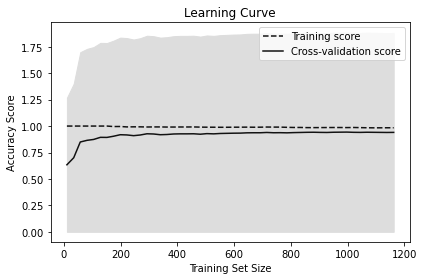

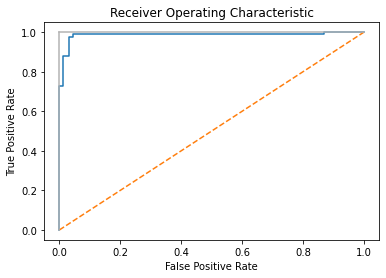

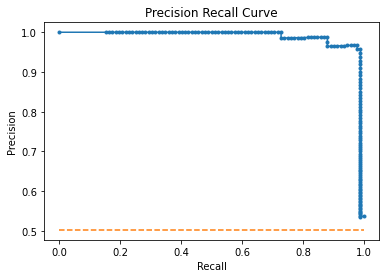

Best F1 score: 0.967741935483871 Best threshold value: 0.1


,Accuracy,Precision,Recall,F1,F2,ROCAUC,PRAUC
0,0.967213,0.957447,0.978261,0.967742,0.974026,0.985189,0.989149


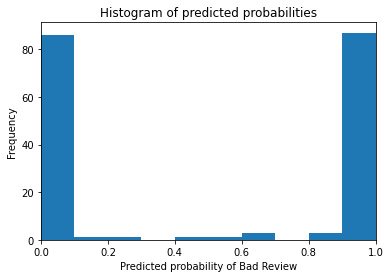

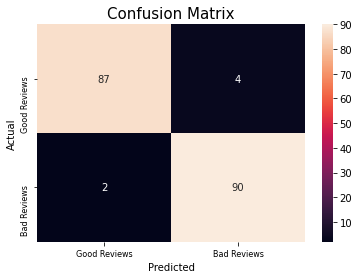

In [167]:
run_mod(nb,X_train_bin,y_train,X_val_bin,y_val)
nb_results1 = run_mod.results
nb_results1

### Logistic Regression

              precision    recall  f1-score   support

           0       0.97      0.93      0.95        91
           1       0.94      0.97      0.95        92

    accuracy                           0.95       183
   macro avg       0.95      0.95      0.95       183
weighted avg       0.95      0.95      0.95       183



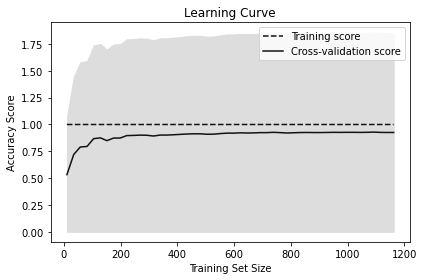

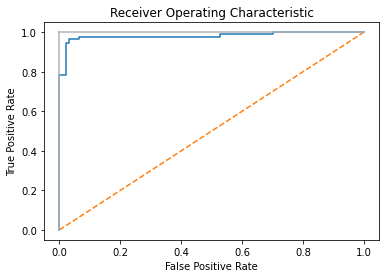

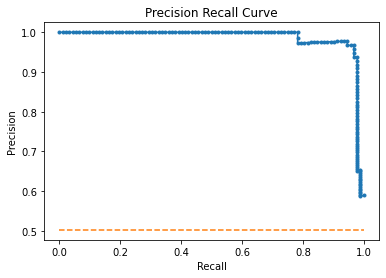

Best F1 score: 0.9518716577540107 Best threshold value: 0.1


,Accuracy,Precision,Recall,F1,F2,ROCAUC,PRAUC
0,0.95082,0.936842,0.967391,0.951872,0.961123,0.981605,0.986347


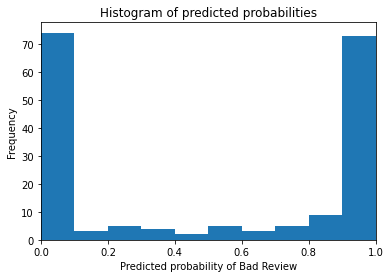

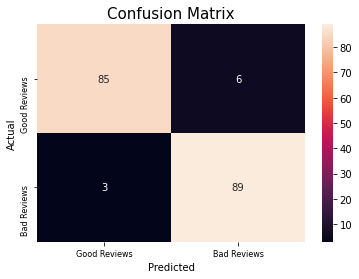

In [168]:
run_mod(lr,X_train_bin,y_train,X_val_bin,y_val)
lr_results1 = run_mod.results
lr_results1

### Random Forest

              precision    recall  f1-score   support

           0       0.89      0.89      0.89        91
           1       0.89      0.89      0.89        92

    accuracy                           0.89       183
   macro avg       0.89      0.89      0.89       183
weighted avg       0.89      0.89      0.89       183



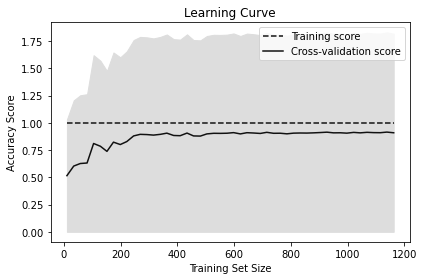

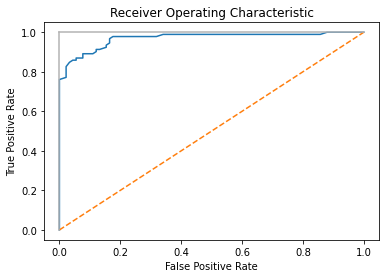

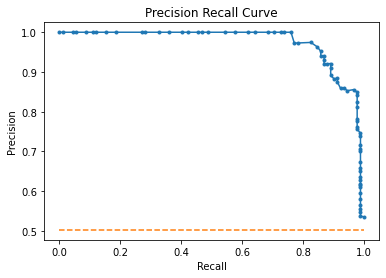

Best F1 score: 0.8913043478260869 Best threshold value: 0.1


,Accuracy,Precision,Recall,F1,F2,ROCAUC,PRAUC
0,0.89071,0.891304,0.891304,0.891304,0.891304,0.969422,0.975352


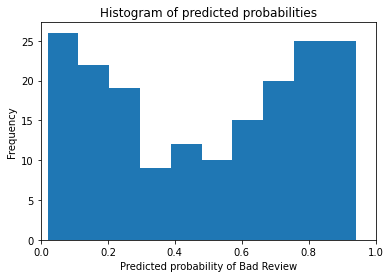

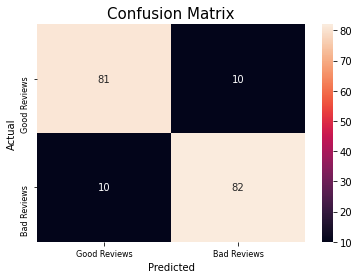

In [169]:
run_mod(rf,X_train_bin,y_train,X_val_bin,y_val)
rf_results1 = run_mod.results
rf_results1

### Support Vector Machines

              precision    recall  f1-score   support

           0       0.96      0.90      0.93        91
           1       0.91      0.97      0.94        92

    accuracy                           0.93       183
   macro avg       0.94      0.93      0.93       183
weighted avg       0.94      0.93      0.93       183



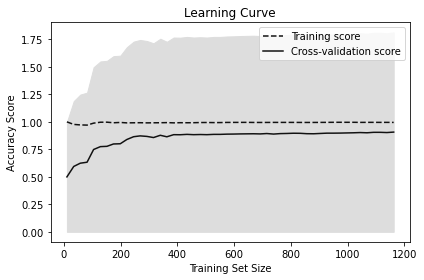

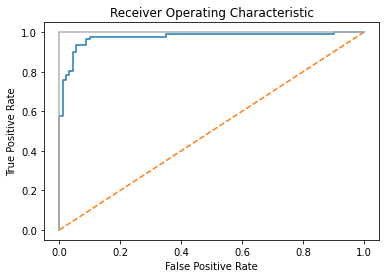

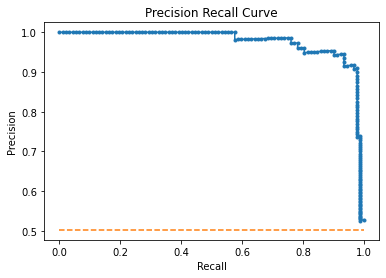

Best F1 score: 0.9368421052631578 Best threshold value: 0.1


,Accuracy,Precision,Recall,F1,F2,ROCAUC,PRAUC
0,0.934426,0.908163,0.967391,0.936842,0.954936,0.973125,0.977299


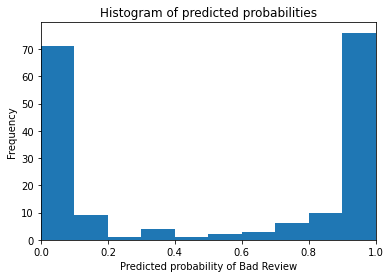

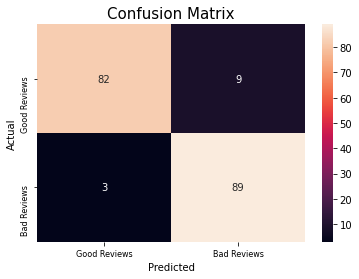

In [170]:
run_mod(svm,X_train_bin,y_train,X_val_bin,y_val)
svm_results1 = run_mod.results
svm_results1

## Feature Presence Bigram

### Naive Bayes

              precision    recall  f1-score   support

           0       0.98      0.95      0.96        91
           1       0.95      0.98      0.96        92

    accuracy                           0.96       183
   macro avg       0.96      0.96      0.96       183
weighted avg       0.96      0.96      0.96       183



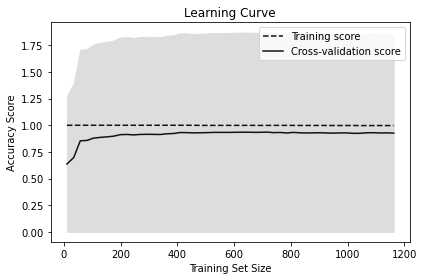

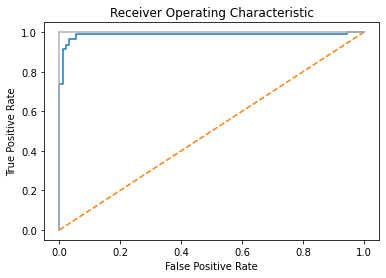

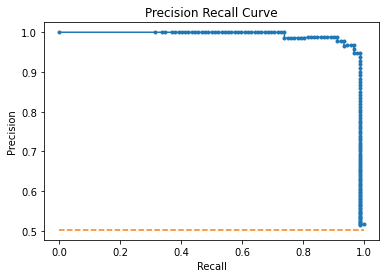

Best F1 score: 0.9625668449197862 Best threshold value: 0.1


,Accuracy,Precision,Recall,F1,F2,ROCAUC,PRAUC
0,0.961749,0.947368,0.978261,0.962567,0.971922,0.985069,0.989742


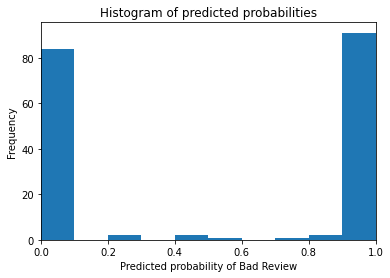

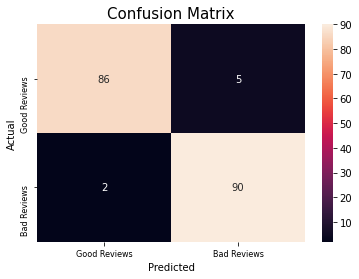

In [308]:
run_mod(nb,X_train_bin_ngram,y_train,X_val_bin_ngram,y_val)
nb_results2 = run_mod.results
nb_results2

### Logistic Regression

              precision    recall  f1-score   support

           0       0.97      0.93      0.95        91
           1       0.94      0.97      0.95        92

    accuracy                           0.95       183
   macro avg       0.95      0.95      0.95       183
weighted avg       0.95      0.95      0.95       183



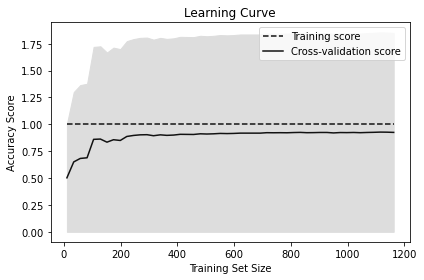

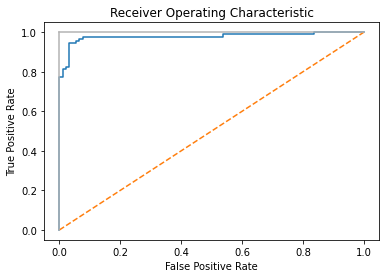

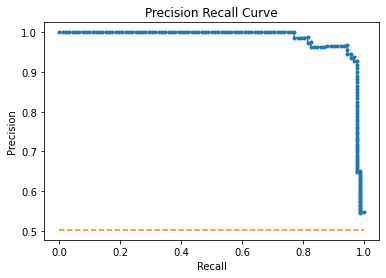

Best F1 score: 0.9518716577540107 Best threshold value: 0.1


,Accuracy,Precision,Recall,F1,F2,ROCAUC,PRAUC
0,0.95082,0.936842,0.967391,0.951872,0.961123,0.978261,0.984065


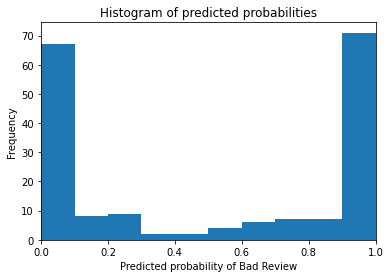

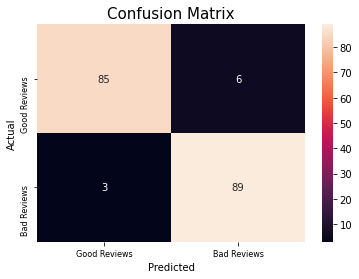

In [309]:
run_mod(lr,X_train_bin_ngram,y_train,X_val_bin_ngram,y_val)
lr_results2 = run_mod.results
lr_results2

### Random Forest

              precision    recall  f1-score   support

           0       0.91      0.95      0.93        91
           1       0.94      0.91      0.93        92

    accuracy                           0.93       183
   macro avg       0.93      0.93      0.93       183
weighted avg       0.93      0.93      0.93       183



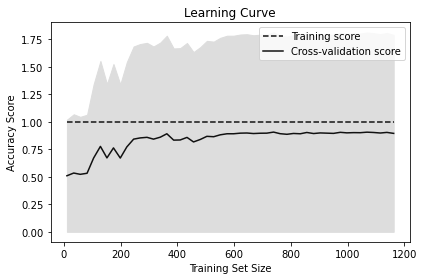

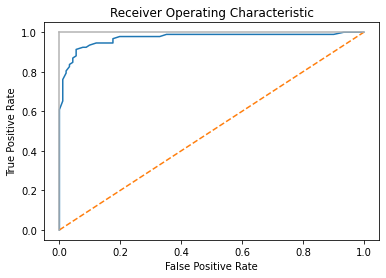

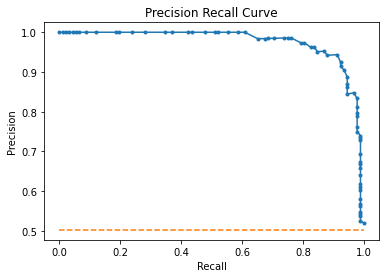

Best F1 score: 0.9281767955801105 Best threshold value: 0.1


,Accuracy,Precision,Recall,F1,F2,ROCAUC,PRAUC
0,0.928962,0.94382,0.913043,0.928177,0.919037,0.970676,0.976113


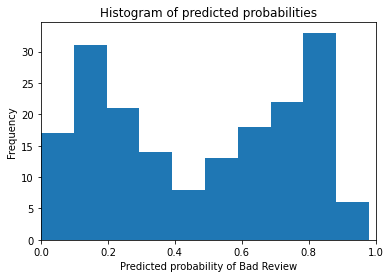

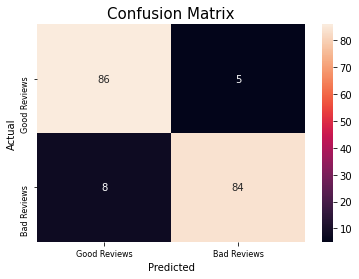

In [310]:
run_mod(rf,X_train_bin_ngram,y_train,X_val_bin_ngram,y_val)
rf_results2 = run_mod.results
rf_results2

### Support Vector Machines

              precision    recall  f1-score   support

           0       0.92      0.95      0.93        91
           1       0.94      0.92      0.93        92

    accuracy                           0.93       183
   macro avg       0.93      0.93      0.93       183
weighted avg       0.93      0.93      0.93       183



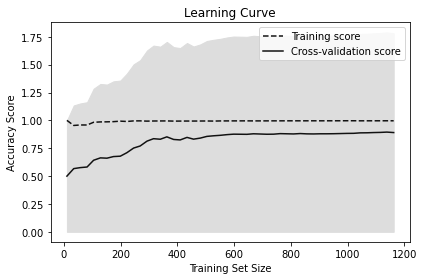

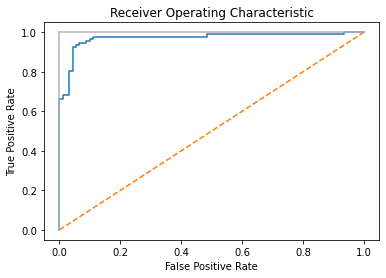

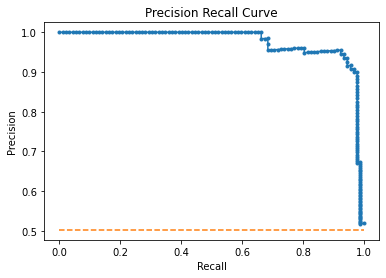

Best F1 score: 0.934065934065934 Best threshold value: 0.1


,Accuracy,Precision,Recall,F1,F2,ROCAUC,PRAUC
0,0.934426,0.944444,0.923913,0.934066,0.927948,0.970616,0.975789


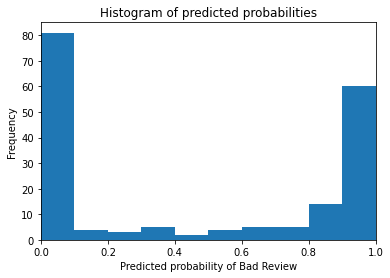

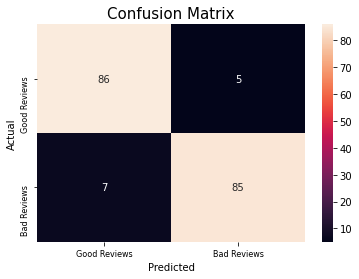

In [311]:
run_mod(svm,X_train_bin_ngram,y_train,X_val_bin_ngram,y_val)
svm_results2 = run_mod.results
svm_results2

## BOW

### Naive Bayes

              precision    recall  f1-score   support

           0       0.99      0.98      0.98        91
           1       0.98      0.99      0.98        92

    accuracy                           0.98       183
   macro avg       0.98      0.98      0.98       183
weighted avg       0.98      0.98      0.98       183



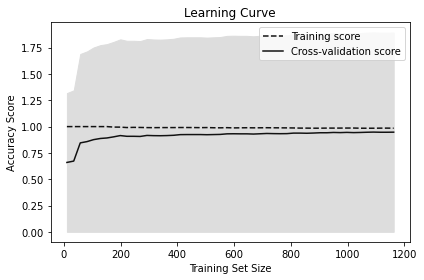

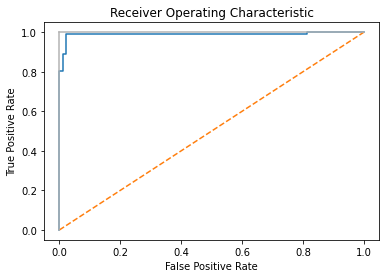

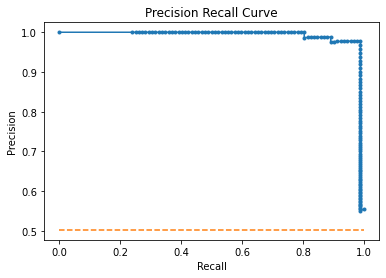

Best F1 score: 0.9837837837837837 Best threshold value: 0.1


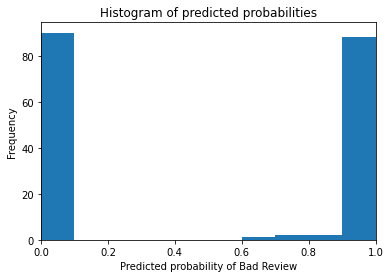

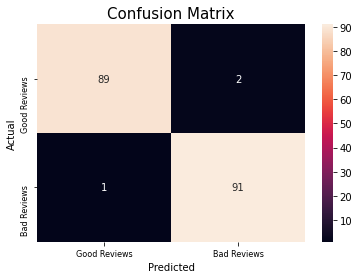

In [312]:
run_mod(nb,X_train_bow,y_train,X_val_bow,y_val)

In [313]:
nb_results3 = run_mod.results
nb_results3

,Accuracy,Precision,Recall,F1,F2,ROCAUC,PRAUC
0,0.983607,0.978495,0.98913,0.983784,0.986985,0.988055,0.991825


### Logistic Regression

              precision    recall  f1-score   support

           0       0.98      0.96      0.97        91
           1       0.96      0.98      0.97        92

    accuracy                           0.97       183
   macro avg       0.97      0.97      0.97       183
weighted avg       0.97      0.97      0.97       183



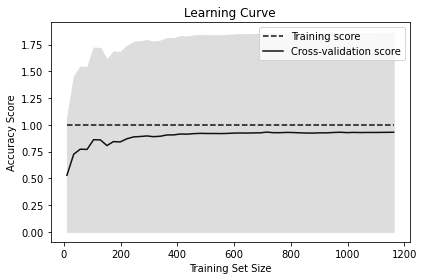

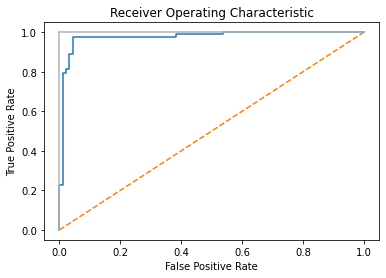

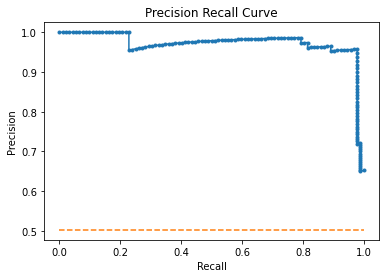

Best F1 score: 0.967741935483871 Best threshold value: 0.1


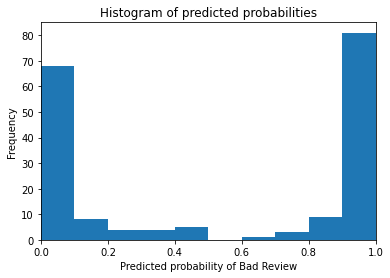

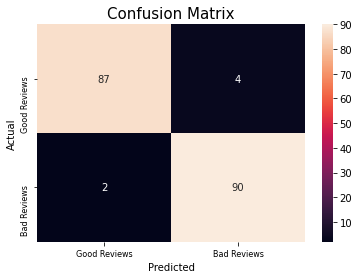

In [314]:
run_mod(lr,X_train_bow,y_train,X_val_bow,y_val)

In [315]:
lr_results3 = run_mod.results
lr_results3

,Accuracy,Precision,Recall,F1,F2,ROCAUC,PRAUC
0,0.967213,0.957447,0.978261,0.967742,0.974026,0.976947,0.972749


### Random Forest

              precision    recall  f1-score   support

           0       0.93      0.92      0.93        91
           1       0.92      0.93      0.93        92

    accuracy                           0.93       183
   macro avg       0.93      0.93      0.93       183
weighted avg       0.93      0.93      0.93       183



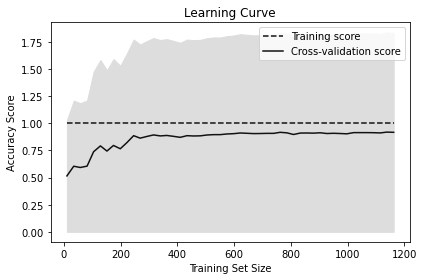

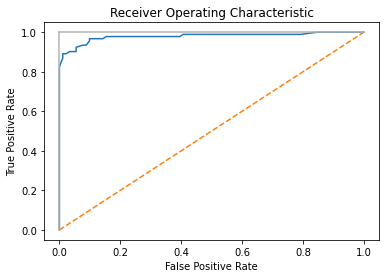

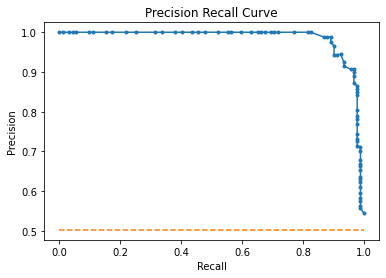

Best F1 score: 0.9297297297297297 Best threshold value: 0.1


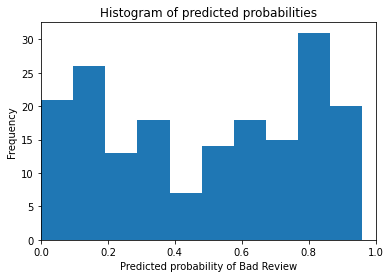

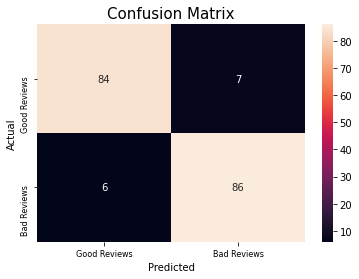

In [316]:
run_mod(rf,X_train_bow,y_train,X_val_bow,y_val)

In [317]:
rf_results3 = run_mod.results
rf_results3

,Accuracy,Precision,Recall,F1,F2,ROCAUC,PRAUC
0,0.928962,0.924731,0.934783,0.92973,0.932755,0.979336,0.984853


### SVM

              precision    recall  f1-score   support

           0       0.98      0.88      0.92        91
           1       0.89      0.98      0.93        92

    accuracy                           0.93       183
   macro avg       0.93      0.93      0.93       183
weighted avg       0.93      0.93      0.93       183



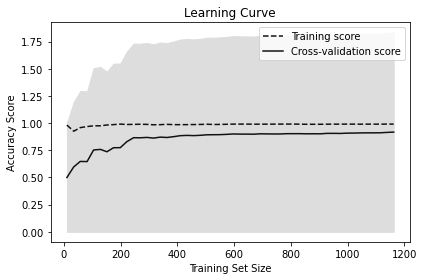

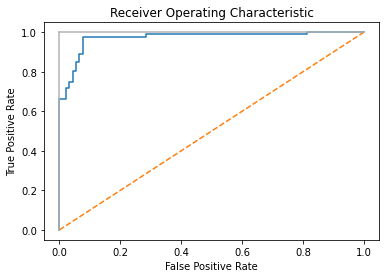

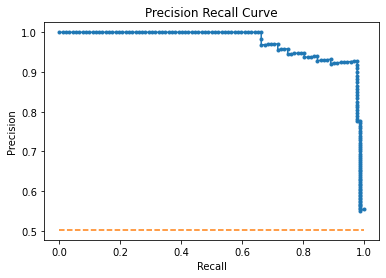

Best F1 score: 0.9326424870466321 Best threshold value: 0.1


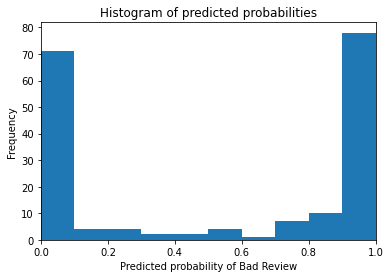

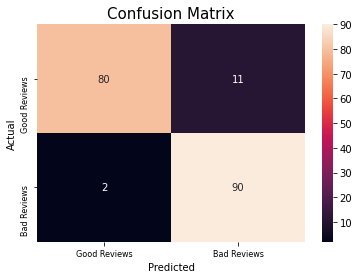

In [318]:
run_mod(svm,X_train_bow,y_train,X_val_bow,y_val)

In [320]:
svm_results3 = run_mod.results
svm_results3

,Accuracy,Precision,Recall,F1,F2,ROCAUC,PRAUC
0,0.928962,0.891089,0.978261,0.932642,0.959488,0.971452,0.974518


## NGRAMs

### Naive Bayes

              precision    recall  f1-score   support

           0       0.97      0.96      0.96        91
           1       0.96      0.97      0.96        92

    accuracy                           0.96       183
   macro avg       0.96      0.96      0.96       183
weighted avg       0.96      0.96      0.96       183



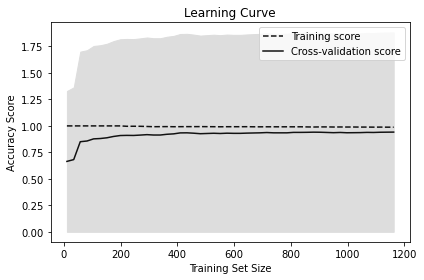

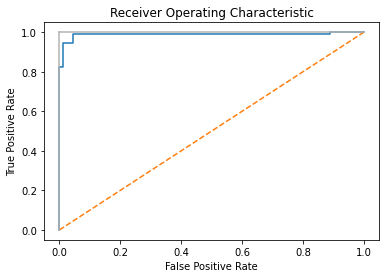

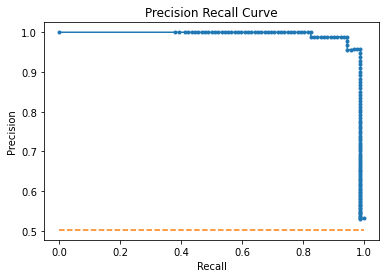

Best F1 score: 0.9621621621621621 Best threshold value: 0.1


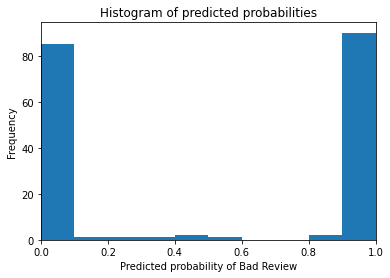

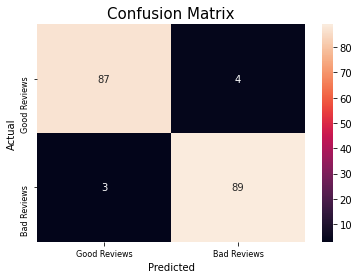

In [321]:
run_mod(nb,X_train_ngram,y_train,X_val_ngram,y_val)

In [322]:
nb_results4 = run_mod.results
nb_results4

,Accuracy,Precision,Recall,F1,F2,ROCAUC,PRAUC
0,0.961749,0.956989,0.967391,0.962162,0.965293,0.9871,0.991574


### Logistic Regression

              precision    recall  f1-score   support

           0       0.98      0.95      0.96        91
           1       0.95      0.98      0.96        92

    accuracy                           0.96       183
   macro avg       0.96      0.96      0.96       183
weighted avg       0.96      0.96      0.96       183



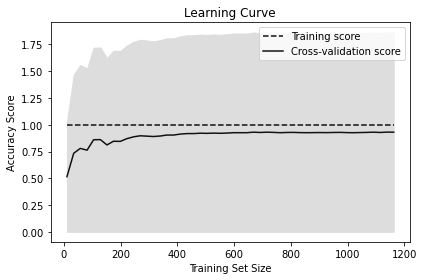

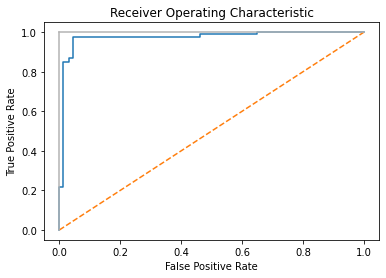

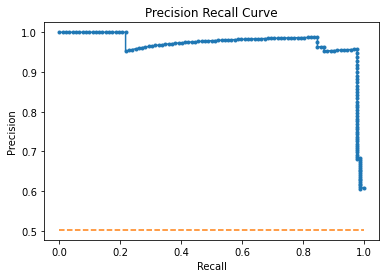

Best F1 score: 0.9625668449197862 Best threshold value: 0.1


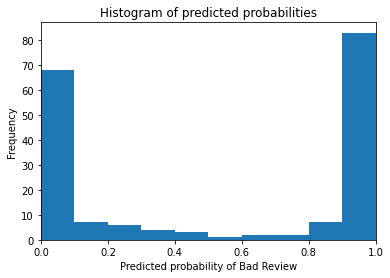

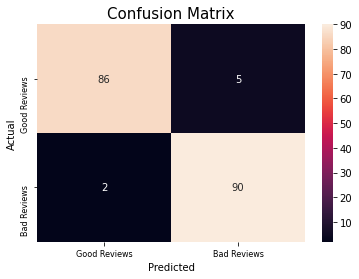

In [323]:
run_mod(lr,X_train_ngram,y_train,X_val_ngram,y_val)

In [324]:
lr_results4 = run_mod.results
lr_results4

,Accuracy,Precision,Recall,F1,F2,ROCAUC,PRAUC
0,0.961749,0.947368,0.978261,0.962567,0.971922,0.975514,0.972204


### Random Forest

              precision    recall  f1-score   support

           0       0.92      0.91      0.92        91
           1       0.91      0.92      0.92        92

    accuracy                           0.92       183
   macro avg       0.92      0.92      0.92       183
weighted avg       0.92      0.92      0.92       183



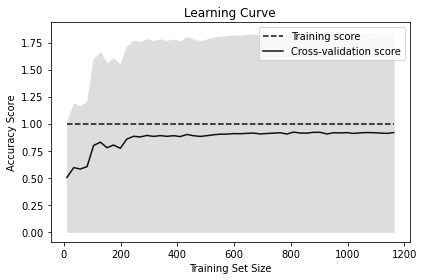

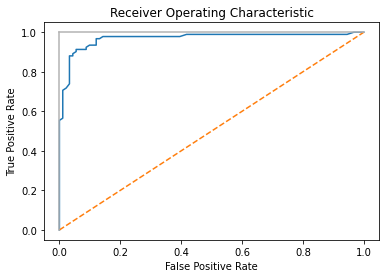

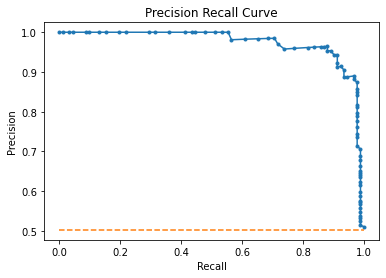

Best F1 score: 0.918918918918919 Best threshold value: 0.1


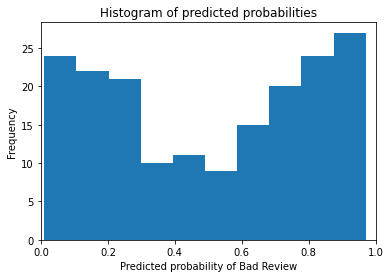

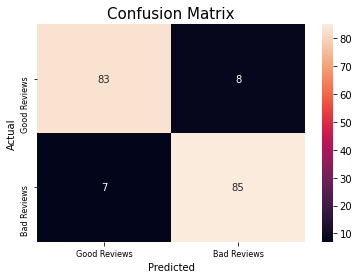

In [325]:
run_mod(rf,X_train_ngram,y_train,X_val_ngram,y_val)

In [326]:
rf_results4 = run_mod.results
rf_results4

,Accuracy,Precision,Recall,F1,F2,ROCAUC,PRAUC
0,0.918033,0.913978,0.923913,0.918919,0.921909,0.969123,0.973975


### Support Vector Machine

              precision    recall  f1-score   support

           0       0.98      0.89      0.93        91
           1       0.90      0.98      0.94        92

    accuracy                           0.93       183
   macro avg       0.94      0.93      0.93       183
weighted avg       0.94      0.93      0.93       183



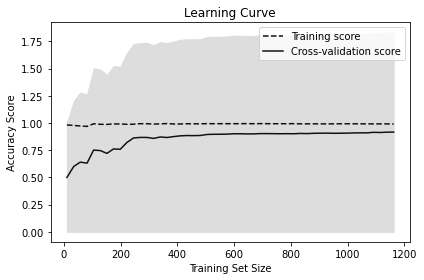

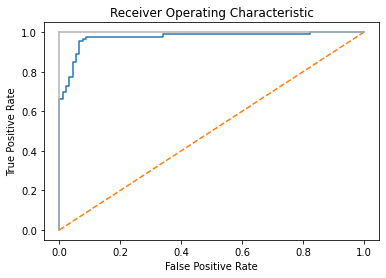

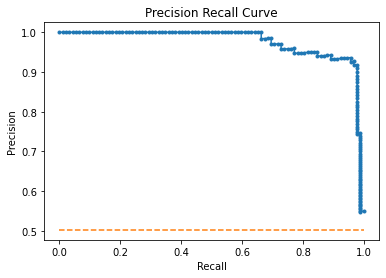

Best F1 score: 0.9375 Best threshold value: 0.1


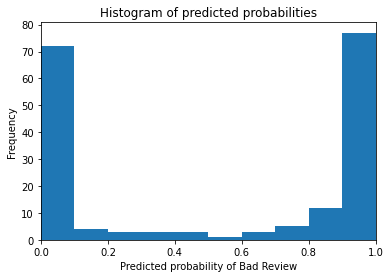

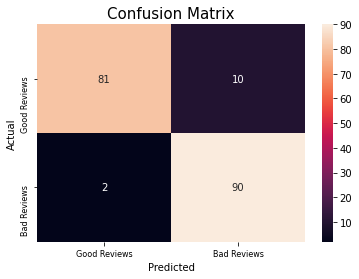

In [327]:
run_mod(svm,X_train_ngram,y_train,X_val_ngram,y_val)

In [328]:
svm_results4 = run_mod.results
svm_results4

,Accuracy,Precision,Recall,F1,F2,ROCAUC,PRAUC
0,0.934426,0.9,0.978261,0.9375,0.961538,0.973005,0.97661


## TFIDF Unigram

### Naive Bayes

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        91
           1       0.96      0.96      0.96        92

    accuracy                           0.96       183
   macro avg       0.96      0.96      0.96       183
weighted avg       0.96      0.96      0.96       183



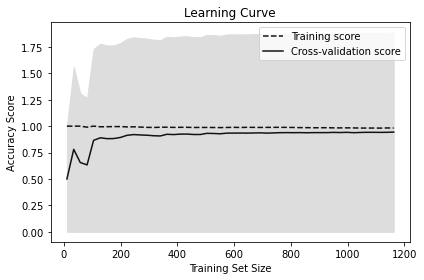

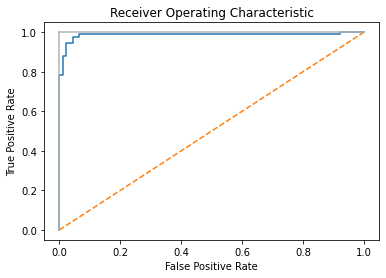

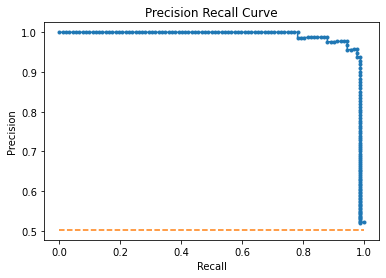

Best F1 score: 0.9565217391304348 Best threshold value: 0.1


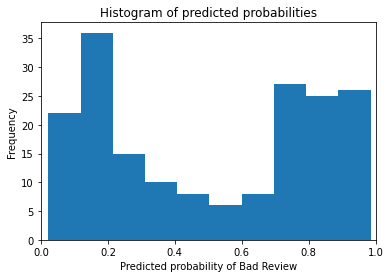

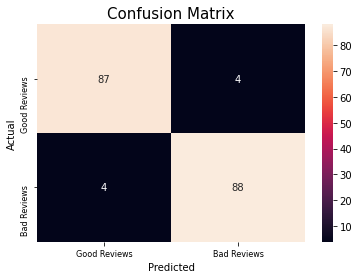

In [329]:
run_mod(nb,X_train_tfidf1,y_train,X_val_tfidf1,y_val)

In [330]:
nb_results5 = run_mod.results
nb_results5

,Accuracy,Precision,Recall,F1,F2,ROCAUC,PRAUC
0,0.956284,0.956522,0.956522,0.956522,0.956522,0.985308,0.98993


### Logistic Regression

              precision    recall  f1-score   support

           0       0.98      0.95      0.96        91
           1       0.95      0.98      0.96        92

    accuracy                           0.96       183
   macro avg       0.96      0.96      0.96       183
weighted avg       0.96      0.96      0.96       183



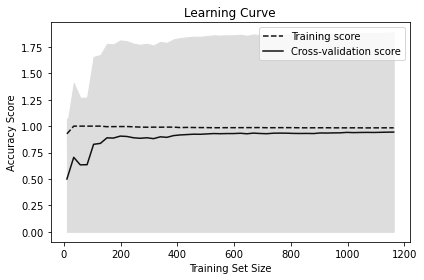

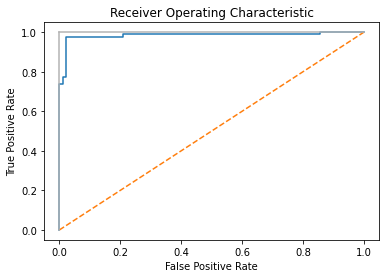

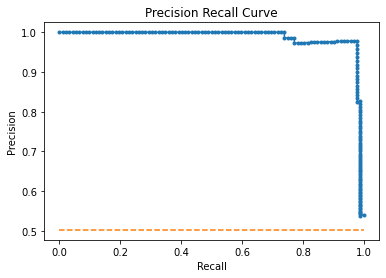

Best F1 score: 0.9625668449197862 Best threshold value: 0.1


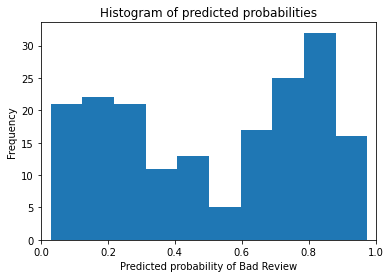

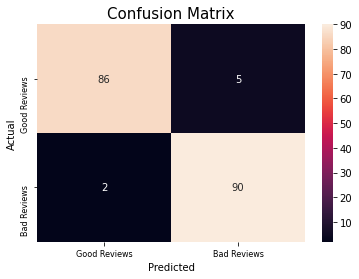

In [331]:
run_mod(lr,X_train_tfidf1,y_train,X_val_tfidf1,y_val)

In [332]:
lr_results5 = run_mod.results
lr_results5

,Accuracy,Precision,Recall,F1,F2,ROCAUC,PRAUC
0,0.961749,0.947368,0.978261,0.962567,0.971922,0.983516,0.98762


### Random Forest

              precision    recall  f1-score   support

           0       0.96      0.93      0.94        91
           1       0.94      0.96      0.95        92

    accuracy                           0.95       183
   macro avg       0.95      0.95      0.95       183
weighted avg       0.95      0.95      0.95       183



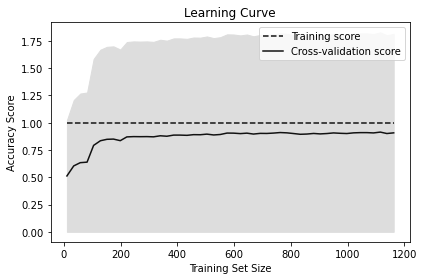

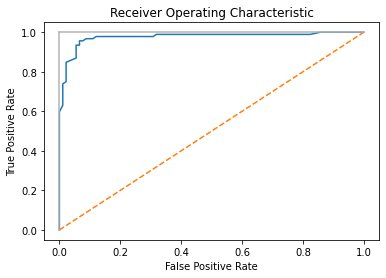

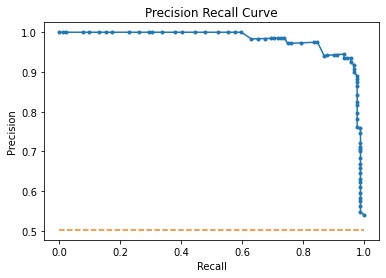

Best F1 score: 0.9462365591397849 Best threshold value: 0.1


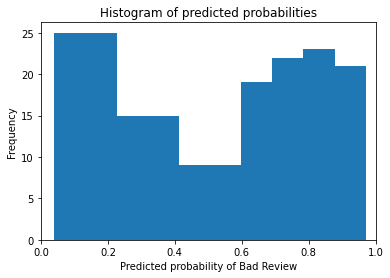

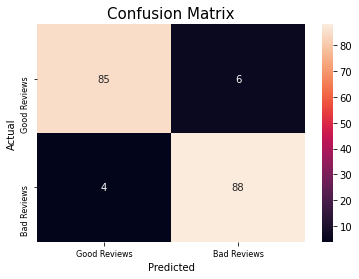

In [333]:
run_mod(rf,X_train_tfidf1,y_train,X_val_tfidf1,y_val)

In [334]:
rf_results5 = run_mod.results
rf_results5

,Accuracy,Precision,Recall,F1,F2,ROCAUC,PRAUC
0,0.945355,0.93617,0.956522,0.946237,0.952381,0.975753,0.979632


### Support Vector Machine

              precision    recall  f1-score   support

           0       0.98      0.95      0.96        91
           1       0.95      0.98      0.96        92

    accuracy                           0.96       183
   macro avg       0.96      0.96      0.96       183
weighted avg       0.96      0.96      0.96       183



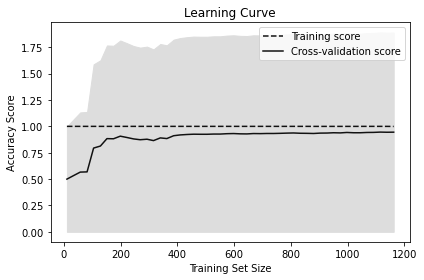

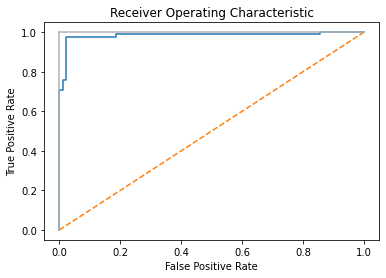

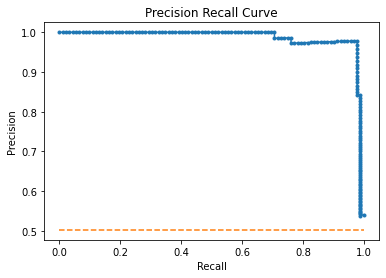

Best F1 score: 0.9625668449197862 Best threshold value: 0.1


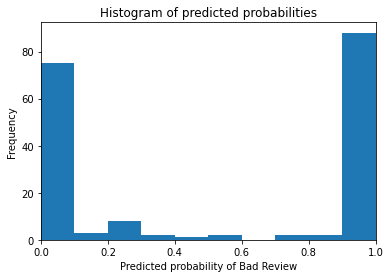

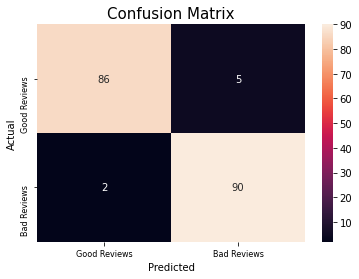

In [335]:
run_mod(svm,X_train_tfidf1,y_train,X_val_tfidf1,y_val)

In [336]:
svm_results5 = run_mod.results
svm_results5

,Accuracy,Precision,Recall,F1,F2,ROCAUC,PRAUC
0,0.961749,0.947368,0.978261,0.962567,0.971922,0.983278,0.987156


## TFIDF Bigrams

###  Naive Bayes

              precision    recall  f1-score   support

           0       0.98      0.93      0.96        91
           1       0.94      0.98      0.96        92

    accuracy                           0.96       183
   macro avg       0.96      0.96      0.96       183
weighted avg       0.96      0.96      0.96       183



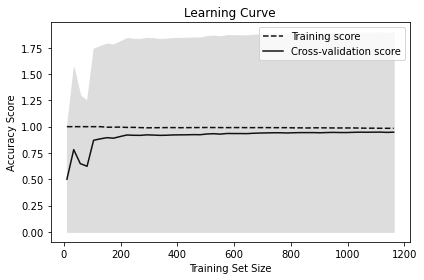

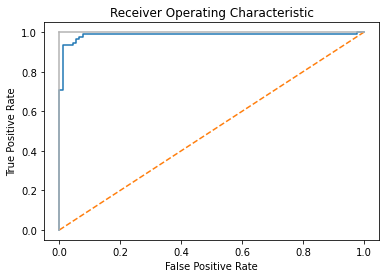

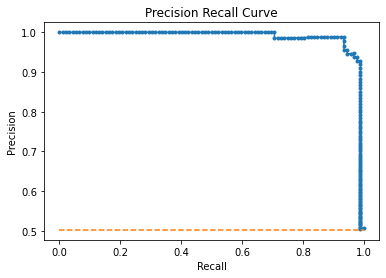

Best F1 score: 0.9574468085106383 Best threshold value: 0.1


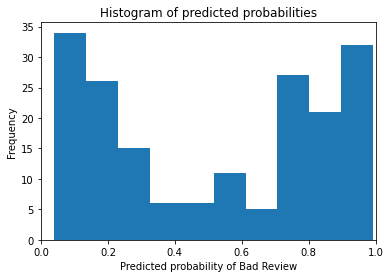

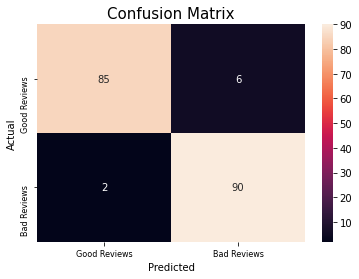

In [337]:
run_mod(nb,X_train_tfidf2,y_train,X_val_tfidf2,y_val)

In [338]:
nb_results6 = run_mod.results
nb_results6

,Accuracy,Precision,Recall,F1,F2,ROCAUC,PRAUC
0,0.956284,0.9375,0.978261,0.957447,0.969828,0.983636,0.988525


### Logistic Regression

              precision    recall  f1-score   support

           0       0.98      0.95      0.96        91
           1       0.95      0.98      0.96        92

    accuracy                           0.96       183
   macro avg       0.96      0.96      0.96       183
weighted avg       0.96      0.96      0.96       183



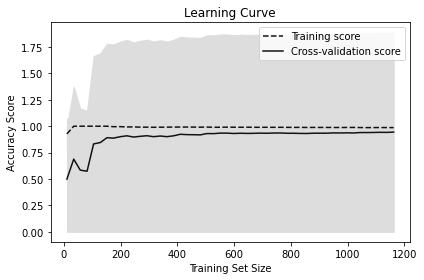

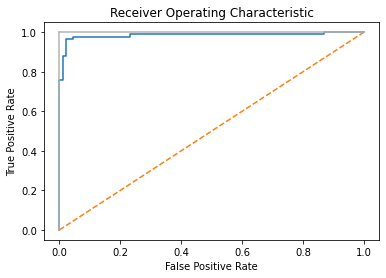

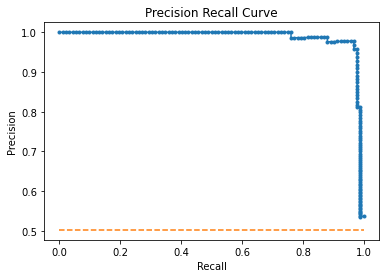

Best F1 score: 0.9625668449197862 Best threshold value: 0.1


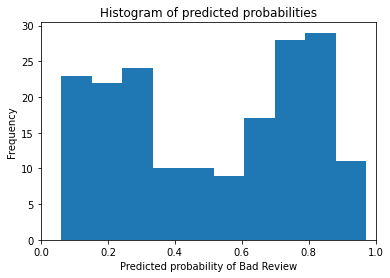

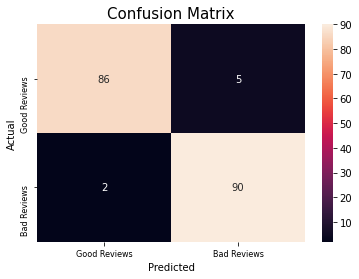

In [339]:
run_mod(lr,X_train_tfidf2,y_train,X_val_tfidf2,y_val)

In [340]:
lr_results6 = run_mod.results
lr_results6

,Accuracy,Precision,Recall,F1,F2,ROCAUC,PRAUC
0,0.961749,0.947368,0.978261,0.962567,0.971922,0.984353,0.988885


### Random Forest

              precision    recall  f1-score   support

           0       0.93      0.92      0.93        91
           1       0.92      0.93      0.93        92

    accuracy                           0.93       183
   macro avg       0.93      0.93      0.93       183
weighted avg       0.93      0.93      0.93       183



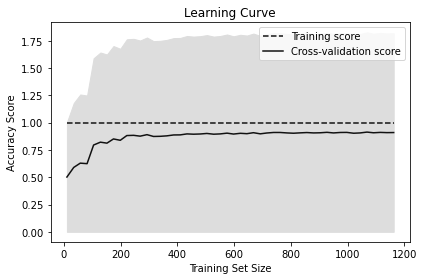

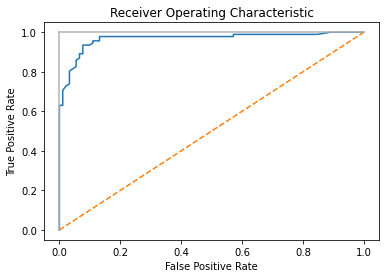

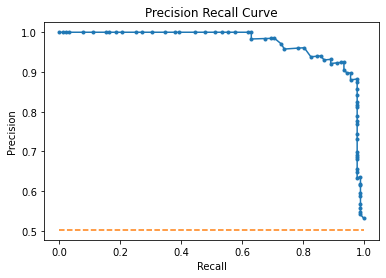

Best F1 score: 0.9297297297297297 Best threshold value: 0.1


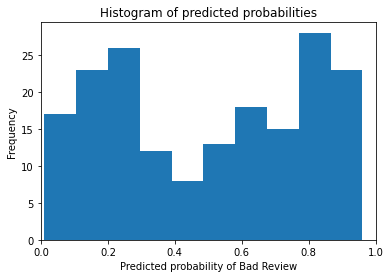

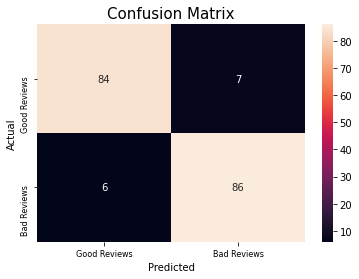

In [341]:
run_mod(rf,X_train_tfidf2,y_train,X_val_tfidf2,y_val)

In [342]:
rf_results6 = run_mod.results
rf_results6

,Accuracy,Precision,Recall,F1,F2,ROCAUC,PRAUC
0,0.928962,0.924731,0.934783,0.92973,0.932755,0.967332,0.972874


### SVM

              precision    recall  f1-score   support

           0       0.98      0.93      0.96        91
           1       0.94      0.98      0.96        92

    accuracy                           0.96       183
   macro avg       0.96      0.96      0.96       183
weighted avg       0.96      0.96      0.96       183



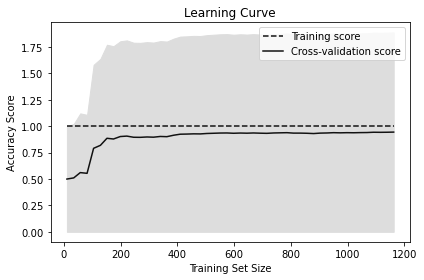

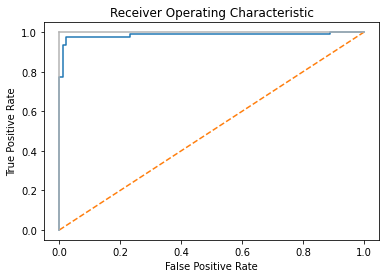

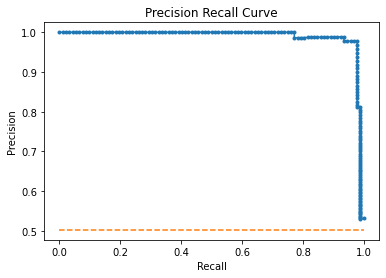

Best F1 score: 0.9574468085106383 Best threshold value: 0.1


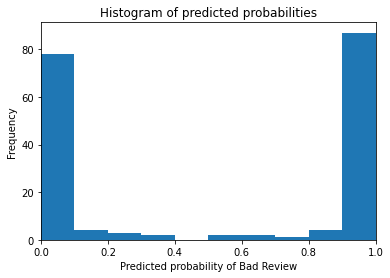

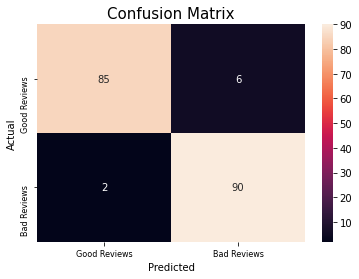

In [343]:
run_mod(svm,X_train_tfidf2,y_train,X_val_tfidf2,y_val)

In [344]:
svm_results6 = run_mod.results
svm_results6

,Accuracy,Precision,Recall,F1,F2,ROCAUC,PRAUC
0,0.956284,0.9375,0.978261,0.957447,0.969828,0.985069,0.989825


# Section 10: Summarised Results Tables

### Feature Presence

In [203]:
models = ["Multinomial NB","Logistic Regression","Random Forest","Support Vector Machine"]

model_summary_bin = pd.concat([nb_results1,lr_results1,rf_results1,svm_results1])
model_summary_bin.set_index([models],inplace = True)
model_summary_bin
model_summary_bin.sort_values(by = "ROCAUC",ascending = False)

,Accuracy,Precision,Recall,F1,F2,ROCAUC,PRAUC
Multinomial NB,0.967213,0.957447,0.978261,0.967742,0.974026,0.985189,0.989149
Logistic Regression,0.950820,0.936842,0.967391,0.951872,0.961123,0.981605,0.986347
Support Vector Machine,0.934426,0.908163,0.967391,0.936842,0.954936,0.973125,0.977299
Random Forest,0.890710,0.891304,0.891304,0.891304,0.891304,0.969422,0.975352


### Feature Presence Binary

In [345]:
models = ["Multinomial NB","Logistic Regression","Random Forest","Support Vector Machine"]

model_summary_bin_ngram = pd.concat([nb_results2,lr_results2,rf_results2,svm_results2])
model_summary_bin_ngram.set_index([models],inplace = True)
model_summary_bin_ngram
model_summary_bin_ngram.sort_values(by = "ROCAUC",ascending = False)

,Accuracy,Precision,Recall,F1,F2,ROCAUC,PRAUC
Multinomial NB,0.961749,0.947368,0.978261,0.962567,0.971922,0.985069,0.989742
Logistic Regression,0.950820,0.936842,0.967391,0.951872,0.961123,0.978261,0.984065
Random Forest,0.928962,0.943820,0.913043,0.928177,0.919037,0.970676,0.976113
Support Vector Machine,0.934426,0.944444,0.923913,0.934066,0.927948,0.970616,0.975789


### BOWs

In [346]:
models = ["Multinomial NB","Logistic Regression","Random Forest","Support Vector Machine"]

model_summary_bow = pd.concat([nb_results3,lr_results3,rf_results3,svm_results3])
model_summary_bow.set_index([models],inplace = True)
model_summary_bow
model_summary_bow.sort_values(by = "ROCAUC",ascending = False)

,Accuracy,Precision,Recall,F1,F2,ROCAUC,PRAUC
Multinomial NB,0.983607,0.978495,0.989130,0.983784,0.986985,0.988055,0.991825
Random Forest,0.928962,0.924731,0.934783,0.929730,0.932755,0.979336,0.984853
Logistic Regression,0.967213,0.957447,0.978261,0.967742,0.974026,0.976947,0.972749
Support Vector Machine,0.928962,0.891089,0.978261,0.932642,0.959488,0.971452,0.974518


In [228]:
# Save to csv
#model_summary_bow.to_csv("model_summary_bow.csv")

### Ngram

In [347]:
model_summary_ngram = pd.concat([nb_results4,lr_results4,rf_results4,svm_results4])
model_summary_ngram.set_index([models],inplace = True)
model_summary_ngram.sort_values(by = "ROCAUC",ascending = False)
model_summary_ngram

,Accuracy,Precision,Recall,F1,F2,ROCAUC,PRAUC
Multinomial NB,0.961749,0.956989,0.967391,0.962162,0.965293,0.987100,0.991574
Logistic Regression,0.961749,0.947368,0.978261,0.962567,0.971922,0.975514,0.972204
Random Forest,0.918033,0.913978,0.923913,0.918919,0.921909,0.969123,0.973975
Support Vector Machine,0.934426,0.900000,0.978261,0.937500,0.961538,0.973005,0.976610


In [206]:
# Save to csv
#model_summary_ngram.to_csv("model_summary_ngram.csv")

### TFIDF Unigram

In [348]:
model_summary_tfidf1 = pd.concat([nb_results5,lr_results5,rf_results5,svm_results5])
model_summary_tfidf1.set_index([models],inplace = True)
model_summary_tfidf1.sort_values(by = "ROCAUC",ascending = False)
model_summary_tfidf1

,Accuracy,Precision,Recall,F1,F2,ROCAUC,PRAUC
Multinomial NB,0.956284,0.956522,0.956522,0.956522,0.956522,0.985308,0.989930
Logistic Regression,0.961749,0.947368,0.978261,0.962567,0.971922,0.983516,0.987620
Random Forest,0.945355,0.936170,0.956522,0.946237,0.952381,0.975753,0.979632
Support Vector Machine,0.961749,0.947368,0.978261,0.962567,0.971922,0.983278,0.987156


In [208]:
# Save to csv
#model_summary_tfidf1.to_csv("model_summary_tfidf_bow.csv")

### TFIDF Bigram

In [349]:
model_summary_tfidf2 = pd.concat([nb_results6,lr_results6,rf_results6,svm_results6])
model_summary_tfidf2.set_index([models],inplace = True)
model_summary_tfidf2.sort_values(by = "ROCAUC",ascending = False)
model_summary_tfidf2

,Accuracy,Precision,Recall,F1,F2,ROCAUC,PRAUC
Multinomial NB,0.956284,0.937500,0.978261,0.957447,0.969828,0.983636,0.988525
Logistic Regression,0.961749,0.947368,0.978261,0.962567,0.971922,0.984353,0.988885
Random Forest,0.928962,0.924731,0.934783,0.929730,0.932755,0.967332,0.972874
Support Vector Machine,0.956284,0.937500,0.978261,0.957447,0.969828,0.985069,0.989825


In [350]:
all_ml_models = pd.concat([model_summary_bin,model_summary_bin_ngram,model_summary_bow,model_summary_ngram,model_summary_tfidf1,model_summary_tfidf2])
all_ml_models.index = ['Multinomial NB FP', 'Logistic Regression FP', 'Random Forest FP','Support Vector Machine FP',
                       'Multinomial NB FP BIG', 'Logistic Regression FP BIG', 'Random Forest FP BIG','Support Vector Machine FP BIG',
                       'Multinomial NB BOW', 'Logistic Regression BOW', 'Random Forest BOW',
                       'Support Vector Machine BOW','Multinomial NB BIG', 'Logistic Regression BIG', 'Random Forest BIG',
                       'Support Vector Machine BIG','Multinomial NB TFIDF', 'Logistic Regression TFIDF', 'Random Forest TFIDF',
                       'Support Vector Machine TFIDF','Multinomial NB TFIDF BIG', 'Logistic Regression TFIDF BIG', 'Random Forest TFIDF BIG',
                       'Support Vector Machine TFIDF BIG']

In [367]:
# Change to sort by another metric
all_ml_models.sort_values(by = "ROCAUC",ascending = False)

,Accuracy,Precision,Recall,F1,F2,ROCAUC,PRAUC
Multinomial NB BOW,0.983607,0.978495,0.989130,0.983784,0.986985,0.988055,0.991825
Multinomial NB BIG,0.961749,0.956989,0.967391,0.962162,0.965293,0.987100,0.991574
Multinomial NB TFIDF,0.956284,0.956522,0.956522,0.956522,0.956522,0.985308,0.989930
Multinomial NB FP,0.967213,0.957447,0.978261,0.967742,0.974026,0.985189,0.989149
Support Vector Machine TFIDF BIG,0.956284,0.937500,0.978261,0.957447,0.969828,0.985069,0.989825
Multinomial NB FP BIG,0.961749,0.947368,0.978261,0.962567,0.971922,0.985069,0.989742
Logistic Regression TFIDF BIG,0.961749,0.947368,0.978261,0.962567,0.971922,0.984353,0.988885
Multinomial NB TFIDF BIG,0.956284,0.937500,0.978261,0.957447,0.969828,0.983636,0.988525
Logistic Regression TFIDF,0.961749,0.947368,0.978261,0.962567,0.971922,0.983516,0.987620
Support Vector Machine TFIDF,0.961749,0.947368,0.978261,0.962567,0.971922,0.983278,0.987156


In [392]:
final_text_models = all_ml_models.sort_values(by = "ROCAUC",ascending = False)
final_text_models.to_csv("FinalTextSentimentModels.csv")

# Section 11: Hyperparameter Tuning

In [352]:
best_model = MultinomialNB()
best_model.get_params().keys()

dict_keys(['alpha', 'class_prior', 'fit_prior'])

In [353]:
from pprint import pprint
pprint(best_model.get_params())

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True}


## Alpha

In [354]:
# [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000].
param_range = np.arange(0.001,500,10)
train_scoreNum, test_scoreNum = validation_curve(
                                MultinomialNB(),
                                X = X_train_bow, y = y_train, 
                                param_name = 'alpha', 
                                param_range = param_range, cv = 3)

In [355]:
def valid(train_scoreNum,test_scoreNum):
    
    train_mean = np.mean(train_scoreNum,axis = 1)
    train_std = np.std(train_scoreNum,axis = 1)
    test_mean = np.mean(test_scoreNum,axis = 1)
    test_std = np.std(test_scoreNum,axis = 1)
    
    plt.plot(param_range,train_mean, label = "Training Score", color = "black")
    plt.plot(param_range, test_mean, label = "Cross Validation Score", color = "dimgray")

    plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color = "gray")
    plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color = "gainsboro")

    plt.title("Multinomial Naive Bayes Validation Curve")
    plt.xlabel("Parameter Number")
    plt.ylabel("Accuracy Score")
    plt.tight_layout()
    plt.legend(loc = "best")
    plt.show()

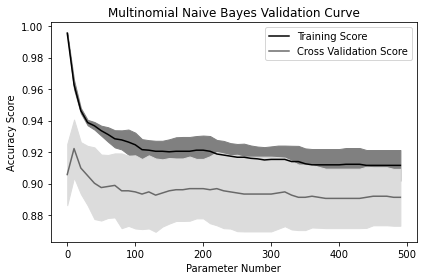

In [356]:
valid(train_scoreNum,test_scoreNum)

Alpha value does not make a lot of difference to either the training or cross validation accuracy score

# Section 12: Grid SearchCV

### Metric Accuracy

In [380]:
parameters = {'alpha':(0.01,1.0,0.01),'fit_prior':[True,False],'class_prior' : [None, [.1,.9],[.2, .8],[.3,.7],[.4,.6],[.5,.5]]}
nb = MultinomialNB()
clf = GridSearchCV(nb,param_grid=parameters, cv = 10, scoring = 'accuracy')
clf.fit(X_train_bow,y_train)

GridSearchCV(cv=10, estimator=MultinomialNB(),
             param_grid={'alpha': (0.01, 1.0, 0.01),
                         'class_prior': [None, [0.1, 0.9], [0.2, 0.8],
                                         [0.3, 0.7], [0.4, 0.6], [0.5, 0.5]],
                         'fit_prior': [True, False]},
             scoring='accuracy')

In [381]:
# Get results
def display(results):
    print(f'Best parameters are: {results.best_params_}')
    print(f'Best score: {results.best_score_}')
    print(f'Best estimator: {results.best_estimator_}')
    print("\n")
    
display(clf)

Best parameters are: {'alpha': 1.0, 'class_prior': [0.1, 0.9], 'fit_prior': True}
Best score: 0.9477231931979215
Best estimator: MultinomialNB(class_prior=[0.1, 0.9])




### Metric Area Under Receiver Operating Characteristic Curve

In [382]:
clf2 = GridSearchCV(nb,param_grid=parameters, cv = 10, scoring = 'roc_auc')
clf2.fit(X_train_bow,y_train)

GridSearchCV(cv=10, estimator=MultinomialNB(),
             param_grid={'alpha': (0.01, 1.0, 0.01),
                         'class_prior': [None, [0.1, 0.9], [0.2, 0.8],
                                         [0.3, 0.7], [0.4, 0.6], [0.5, 0.5]],
                         'fit_prior': [True, False]},
             scoring='roc_auc')

In [383]:
# Get results
def display(results):
    print(f'Best parameters are: {results.best_params_}')
    print(f'Best score: {results.best_score_}')
    print(f'Best estimator: {results.best_estimator_}')
    print("\n")
    
display(clf2)

Best parameters are: {'alpha': 1.0, 'class_prior': [0.1, 0.9], 'fit_prior': True}
Best score: 0.98236874752403
Best estimator: MultinomialNB(class_prior=[0.1, 0.9])




### Best Model with Validation Set

In [384]:
# Set up the best model
best_model = MultinomialNB(alpha = 1,fit_prior = True, class_prior = [0.1,0.9])
best_model.fit(X_train_bow,y_train)

MultinomialNB(alpha=1, class_prior=[0.1, 0.9])

In [385]:
y_pred = best_model.predict(X_val_bow)
print("Training Accuracy:",best_model.score(X_train_bow,y_train))

Training Accuracy: 0.9862353750860289


In [389]:
print("Validation Set Accuracy:",best_model.score(X_val_bow,y_val))

Validation Set Accuracy: 0.9836065573770492


In [390]:
y_pred_best =  best_model.predict(X_val_bow)

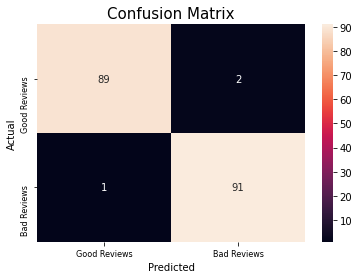

In [391]:
# Confusion Matrix
fig, ax = plt.subplots()
cf_matrix = confusion_matrix(y_val, y_pred)
sns.heatmap(cf_matrix, annot = True, fmt = "d",)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix", fontsize = 15)
_ = ax.xaxis.set_ticklabels(['Good Reviews','Bad Reviews'],fontsize = 8)
_ = ax.yaxis.set_ticklabels(['Good Reviews', 'Bad Reviews'], fontsize = 8)